In [232]:
# ==== CELL 0: CONFIG & DEVICE ====
import os, torch

# Đường dẫn dữ liệu (đúng cấu trúc Train/Validate/Test như bạn dùng)
ROOT = r"C:/TRAIN/Deep Learning/vietnamese-foods/Images"
root_test = f"{ROOT}/Test"

IMG_SIZE = 224
BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [233]:
# ==== CELL 1: TRANSFORMS GIỐNG LÚC TRAIN ====
from torchvision import transforms

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    # Nếu lúc train có Normalize(mean, std) thì PHẢI dùng y chang:
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
])

In [234]:
# ==== CELL 2: HÀM BUILD + GỌI HÀM => TẠO test_loader, class_names ====
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def build_test_loader(root_test_dir, transform, batch_size):
    dataset = ImageFolder(root=root_test_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    class_names = list(dataset.classes)            # thứ tự theo thư mục của ImageFolder
    class_to_idx = dict(dataset.class_to_idx)      # mapping {class_name: idx} của dataset
    return loader, class_names, class_to_idx

# >>> GỌI HÀM (rất hay bị quên)
test_loader, class_names, ds_class_to_idx = build_test_loader(root_test, test_transform, BATCH_SIZE)

print("Số lớp:", len(class_names))
print("Ví dụ lớp:", class_names[:33])

Số lớp: 33
Ví dụ lớp: ['Banh beo', 'Banh bot loc', 'Banh can', 'Banh canh', 'Banh chung', 'Banh cuon', 'Banh duc', 'Banh gio', 'Banh khot', 'Banh mi', 'Banh pia', 'Banh tet', 'Banh trang nuong', 'Banh xeo', 'Bun bo Hue', 'Bun dau mam tom', 'Bun mam', 'Bun rieu', 'Bun thit nuong', 'Ca kho to', 'Canh chua', 'Cao lau', 'Chao long', 'Com tam', 'Goi cuon', 'Hu tieu', 'Mi quang', 'Nem chua', 'Pho', 'Xoi xeo', 'banh_da_lon', 'banh_tieu', 'banh_trung_thu']


In [235]:
# === CELL 3: CORE + HELPERS (giữ nguyên class_names đã nạp ở Cell 2) ===
import os, json, numpy as np, torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

assert "class_names" in globals(), "Bạn phải nạp class_names ở Cell 2 trước cell này!"
NUM_CLASSES = len(class_names)
name2idx = {n:i for i,n in enumerate(class_names)}

def make_remap(src_class_to_idx: dict, target_name2idx: dict):
    """Tạo bảng remap index của dataset loader -> index theo class_names chuẩn."""
    ds_idx2name = {v:k for k,v in src_class_to_idx.items()}
    return {src_idx: target_name2idx[ds_idx2name[src_idx]] for src_idx in ds_idx2name}


@torch.no_grad()
def collect_logits(model, loader, device, remap=None):
    """
    Trả về y_true, y_pred, y_prob với cùng thứ tự class_names đã cố định.
    remap: dict idx_dataset -> idx_chuẩn (nếu cần)
    """
    y_true, y_pred, y_prob = [], [], []

    model.eval()
    # dtype của model (thường là float32)
    model_dtype = next(model.parameters()).dtype

    for x, y in loader:
        # Đưa ảnh về đúng device + dtype của model
        x = x.to(device=device, dtype=model_dtype)

        # Remap nhãn nếu dataset idx khác class_names
        if remap is not None:
            # giữ y trên CPU vì chỉ dùng để so sánh/stack
            y = torch.as_tensor([remap[int(t)] for t in y], dtype=torch.long)
        else:
            y = y.detach().to("cpu", dtype=torch.long)

        # Suy luận
        logits = model(x)                      # logits có dtype == model_dtype
        prob = torch.softmax(logits, dim=1).cpu().numpy()
        pred = prob.argmax(1)

        y_prob.append(prob)
        y_pred.append(pred)
        y_true.append(y.numpy())

    import numpy as np
    return np.concatenate(y_true), np.concatenate(y_pred), np.concatenate(y_prob)


def cm_pretty(cm_counts, labels):
    cm = cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True)
    cm = np.nan_to_num(cm)
    return cm

def draw_cm(cm_counts, run_name, save_dir="images", threshold=0.10, figsize=(12,10), dpi=200):
    import matplotlib.pyplot as plt, seaborn as sns
    os.makedirs(save_dir, exist_ok=True)
    cm = cm_pretty(cm_counts, class_names)
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    sns.heatmap(cm, vmin=0, vmax=1, cmap="Blues", square=True,
                xticklabels=class_names, yticklabels=class_names, ax=ax, cbar_kws={'shrink': .7})
    # annotate: đường chéo + ô >= threshold
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            show = (i == j) or (cm[i,j] >= threshold)
            if show and cm_counts[i,j] > 0:
                ax.text(j+0.5, i+0.5, f"{cm[i,j]*100:.0f}%\n({cm_counts[i,j]})",
                        ha="center", va="center", fontsize=7, color="black")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_title(f"Confusion Matrix (row-norm) – {run_name}", pad=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
    plt.tight_layout()
    out_png = os.path.join(save_dir, f"{run_name}_cm.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight"); plt.show()
    print("✓ Lưu CM:", out_png)


In [236]:
# QUICK CHECK trước khi vẽ
try:
    _ = iter(test_loader)
    assert len(class_names) > 0
    print("✅ test_loader & class_names sẵn sàng.")
except Exception as e:
    print("❌ Lỗi:", e)


✅ test_loader & class_names sẵn sàng.


In [237]:
# ==== CELL 4: PLOTS – CM & TOP CONFUSIONS ====
import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

os.makedirs("images", exist_ok=True)

def plot_confusion(cm_counts, class_names, run_name, save_path, row_norm=True, threshold=0.10, dpi=300):
    """
    cm_counts: ma trận đếm (chưa chuẩn hoá) kích thước [C, C]
    row_norm : chuẩn hoá theo hàng (recall) để nhìn tỉ lệ đúng/sai từng lớp
    threshold: chỉ annotate các ô >= threshold (ngoài đường chéo) để đỡ rối
    """
    C = cm_counts.shape[0]
    cm = cm_counts.astype(float)
    if row_norm:
        cm = cm / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)

    fig, ax = plt.subplots(figsize=(12, 10), dpi=200)
    sns.heatmap(cm, vmin=0, vmax=1, cmap="Blues", square=True,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'shrink': .6}, ax=ax)

    # annotate
    for i in range(C):
        for j in range(C):
            show = (i == j) or (cm[i, j] >= threshold)
            if show and cm_counts[i, j] > 0:
                ax.text(j + 0.5, i + 0.5,
                        f"{cm[i,j]*100:.0f}%\n({cm_counts[i,j]})",
                        ha="center", va="center", fontsize=7, color="black")

    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("True", fontsize=12)
    ax.set_title(f"Confusion Matrix (row-norm) – {run_name}", fontsize=14, pad=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)
    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()

def plot_top_confusions(cm_counts, class_names, run_name, save_path, topk=15, dpi=300):
    """
    Vẽ Top-K cặp dễ nhầm nhất (theo % hàng). Bỏ đường chéo.
    """
    cm = cm_counts.astype(float)
    cm = cm / cm.sum(axis=1, keepdims=True)
    cm = np.nan_to_num(cm)

    pairs = []
    C = cm.shape[0]
    for i in range(C):
        for j in range(C):
            if i == j: 
                continue
            if cm_counts[i, j] == 0:
                continue
            pairs.append((i, j, cm[i, j], cm_counts[i, j]))

    # sort theo tỷ lệ giảm dần
    pairs.sort(key=lambda x: x[2], reverse=True)
    pairs = pairs[:topk]

    if not pairs:
        print("Không có cặp nhầm đáng kể.")
        return

    labels = [f"{class_names[i]} → {class_names[j]}" for (i, j, _, _) in pairs]
    perc   = [100 * p for (_, _, p, _) in pairs]
    counts = [c for (_, _, _, c) in pairs]

    fig, ax = plt.subplots(figsize=(12, 7), dpi=200)
    ax.barh(labels, perc)
    ax.invert_yaxis()
    for k, (p, c) in enumerate(zip(perc, counts)):
        ax.text(p + 0.3, k, f"{p:.1f}% ({c})", va="center", fontsize=10)
    ax.set_xlabel("Tỉ lệ nhầm (%)")
    ax.set_title(f"Top-{len(pairs)} cặp dễ nhầm nhất – {run_name}", fontsize=14, pad=8)
    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()


In [238]:
# ==== CELL 5: EVALUATE ONE RUN ====
import os, json, torch
import numpy as np

# Bạn có thể đổi để khớp folder thật của bạn
RUNS_DIR = "Runs"   # mỗi thư mục con là 1 lần train, có file .mtl/.pt/.pth

from model.mtl_cnn import mtl_cnn_v1
from model.mobilenet_v4 import CustomMobileNetV4  # file bạn đã gửi
from model.efficientnet_b0 import CustomEfficientNetB0

def model_auto(run_name, num_classes=NUM_CLASSES):
    """
    Suy đoán kiến trúc từ tên run. Bạn đang dùng tiền tố:
    - 'mtl-cnn-...'
    - 'mtl-mobilenetv4-...'
    - 'mtl-efficientnetb0-...'
    """
    name = run_name.lower()
    if "mobilenetv4" in name:
        return CustomMobileNetV4(num_classes=num_classes)
    if "efficientnetb0" in name or "efficientnet_b0" in name:
        return CustomEfficientNetB0(num_classes=num_classes)
    # mặc định: CNN tự xây
    return mtl_cnn_v1(num_classes=num_classes)



# --- REPLACE this in Cell 5 ---
from glob import glob
import os, time

EXTS = {".mtl", ".pt", ".pth"}

def find_checkpoint(run_path: str):
    """
    Tìm checkpoint trong run_path và các thư mục con phổ biến.
    Ưu tiên file có 'best' trong tên; nếu không có, lấy file mới nhất.
    """
    # các pattern hay gặp; ** để đảm bảo quét sâu
    patterns = [
        "*", "checkpoints/*", "checkpoint/*", "ckpt*/*",
        "models/*", "weights/*", "**/*"
    ]
    cands = []
    for pat in patterns:
        for p in glob(os.path.join(run_path, pat), recursive=True):
            if os.path.isfile(p) and os.path.splitext(p)[1].lower() in EXTS:
                cands.append(p)

    if not cands:
        return None

    # chấm điểm: có 'best' được +100, 'ema' +10, 'last' +5; sau đó ưu tiên mtime mới hơn
    def score(p):
        name = os.path.basename(p).lower()
        s = 0
        if "best" in name: s += 100
        if "ema"  in name: s += 10
        if "last" in name: s += 5
        return (s, os.path.getmtime(p))

    cands.sort(key=score, reverse=True)
    chosen = cands[0]
    print(f"  ✓ checkpoint: {os.path.relpath(chosen, run_path)}")
    return chosen

def load_checkpoint(run_path_or_name, ckpt_path, device):
    """
    Tự động tạo model đúng loại dựa theo tên run hoặc object đã truyền vào.
    Trả về model đã load trọng số, .to(device).eval()
    """
    # 1️⃣ Nếu truyền vào là object model (vd: CustomMobileNet, CNN,...)
    if not isinstance(run_path_or_name, (str, bytes, os.PathLike)):
        model = run_path_or_name
        run_name = model.__class__.__name__
    else:
        # 2️⃣ Nếu truyền vào là đường dẫn / tên run
        run_name = os.path.basename(str(run_path_or_name).rstrip(os.sep))
        model = build_model_auto(run_name)

    # 3️⃣ Đưa model lên device
    model = model.to(device).eval()

    # 4️⃣ Load checkpoint đúng device
    state = torch.load(ckpt_path, map_location=device)

    # 5️⃣ Xử lý nhiều định dạng state_dict khác nhau
    if isinstance(state, dict):
        if "state_dict" in state:
            sd = state["state_dict"]
        elif "net" in state:
            sd = state["net"]
        elif "classification_best" in state:
            sd = state["classification_best"]
        elif "model" in state and isinstance(state["model"], dict):
            sd = state["model"]
        else:
            sd = state
    else:
        sd = state

    # 6️⃣ Load vào model
    missing, unexpected = model.load_state_dict(sd, strict=False)
    if missing or unexpected:
        print(f"⚠️  load_state_dict warning → missing: {missing}, unexpected: {unexpected}")

    model = model.float().to(device).eval()
    return model


def evaluate_model_at(run_path, run_name):
    # 1) loader cho TEST (dùng build_test_loader bạn đã viết, nhớ truyền batch_size)
    test_loader = build_test_loader(root_test, test_transform, batch_size=BATCH_SIZE)

    # 2) Remap label nếu cần (dataset.class_to_idx -> class_names)
    ds_idx2name = {v: k for k, v in test_loader.dataset.class_to_idx.items()}
    name2idx = {n: i for i, n in enumerate(class_names)}
    remap = {src_idx: name2idx[ds_idx2name[src_idx]] for src_idx in range(len(ds_idx2name))}

    # 3) lấy checkpoint tốt nhất
    ckpt_path = pick_checkpoint(run_path)  # bạn đã có

    # 4) load model về đúng device + eval
    model = load_checkpoint(run_path, ckpt_path, device)

    # 5) thu logits/predicts
    y_true, y_pred, y_prob = collect_logits(model, test_loader, device, remap=remap)

    # 6) tính các chỉ số và vẽ hình (bạn đã có code sẵn)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    


    return {"run": run_name, "acc": acc, "precision": prec, "recall": rec, "f1": f1}


▶️  Đánh giá: mtl-cnn-20251029-201543


C:\Users\Admin\AppData\Local\Temp\ipykernel_31584\3133259203.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


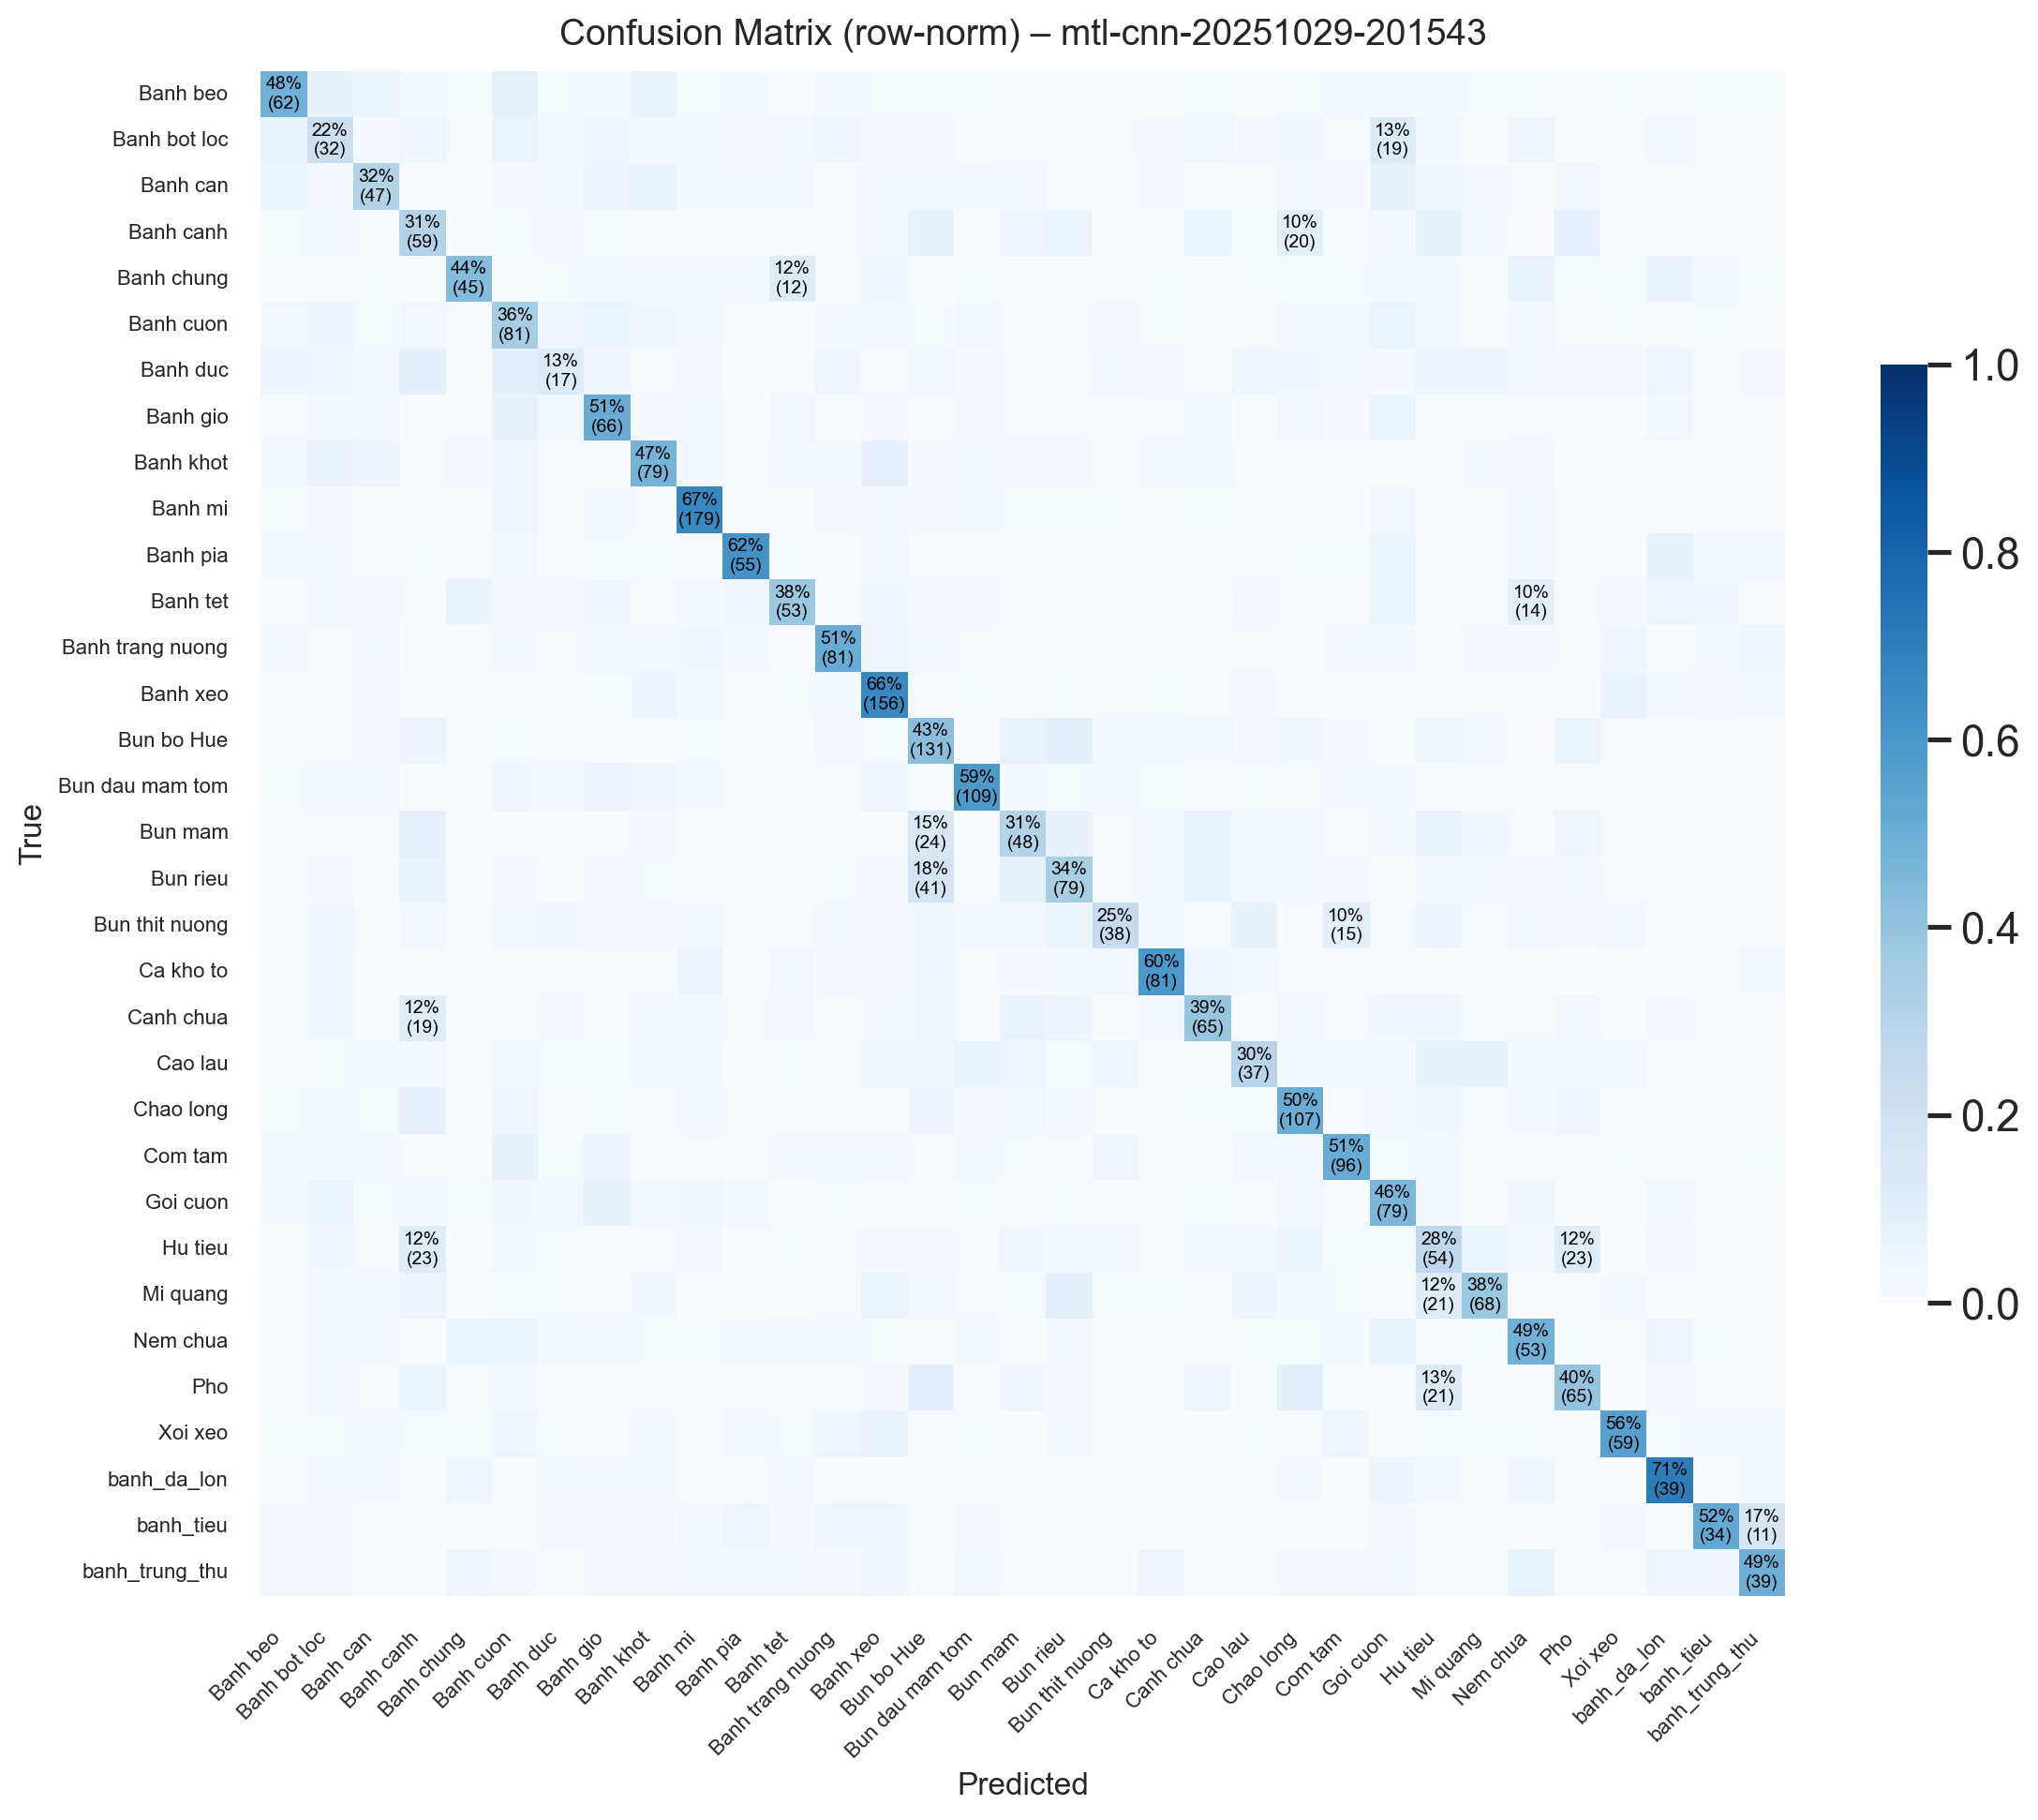

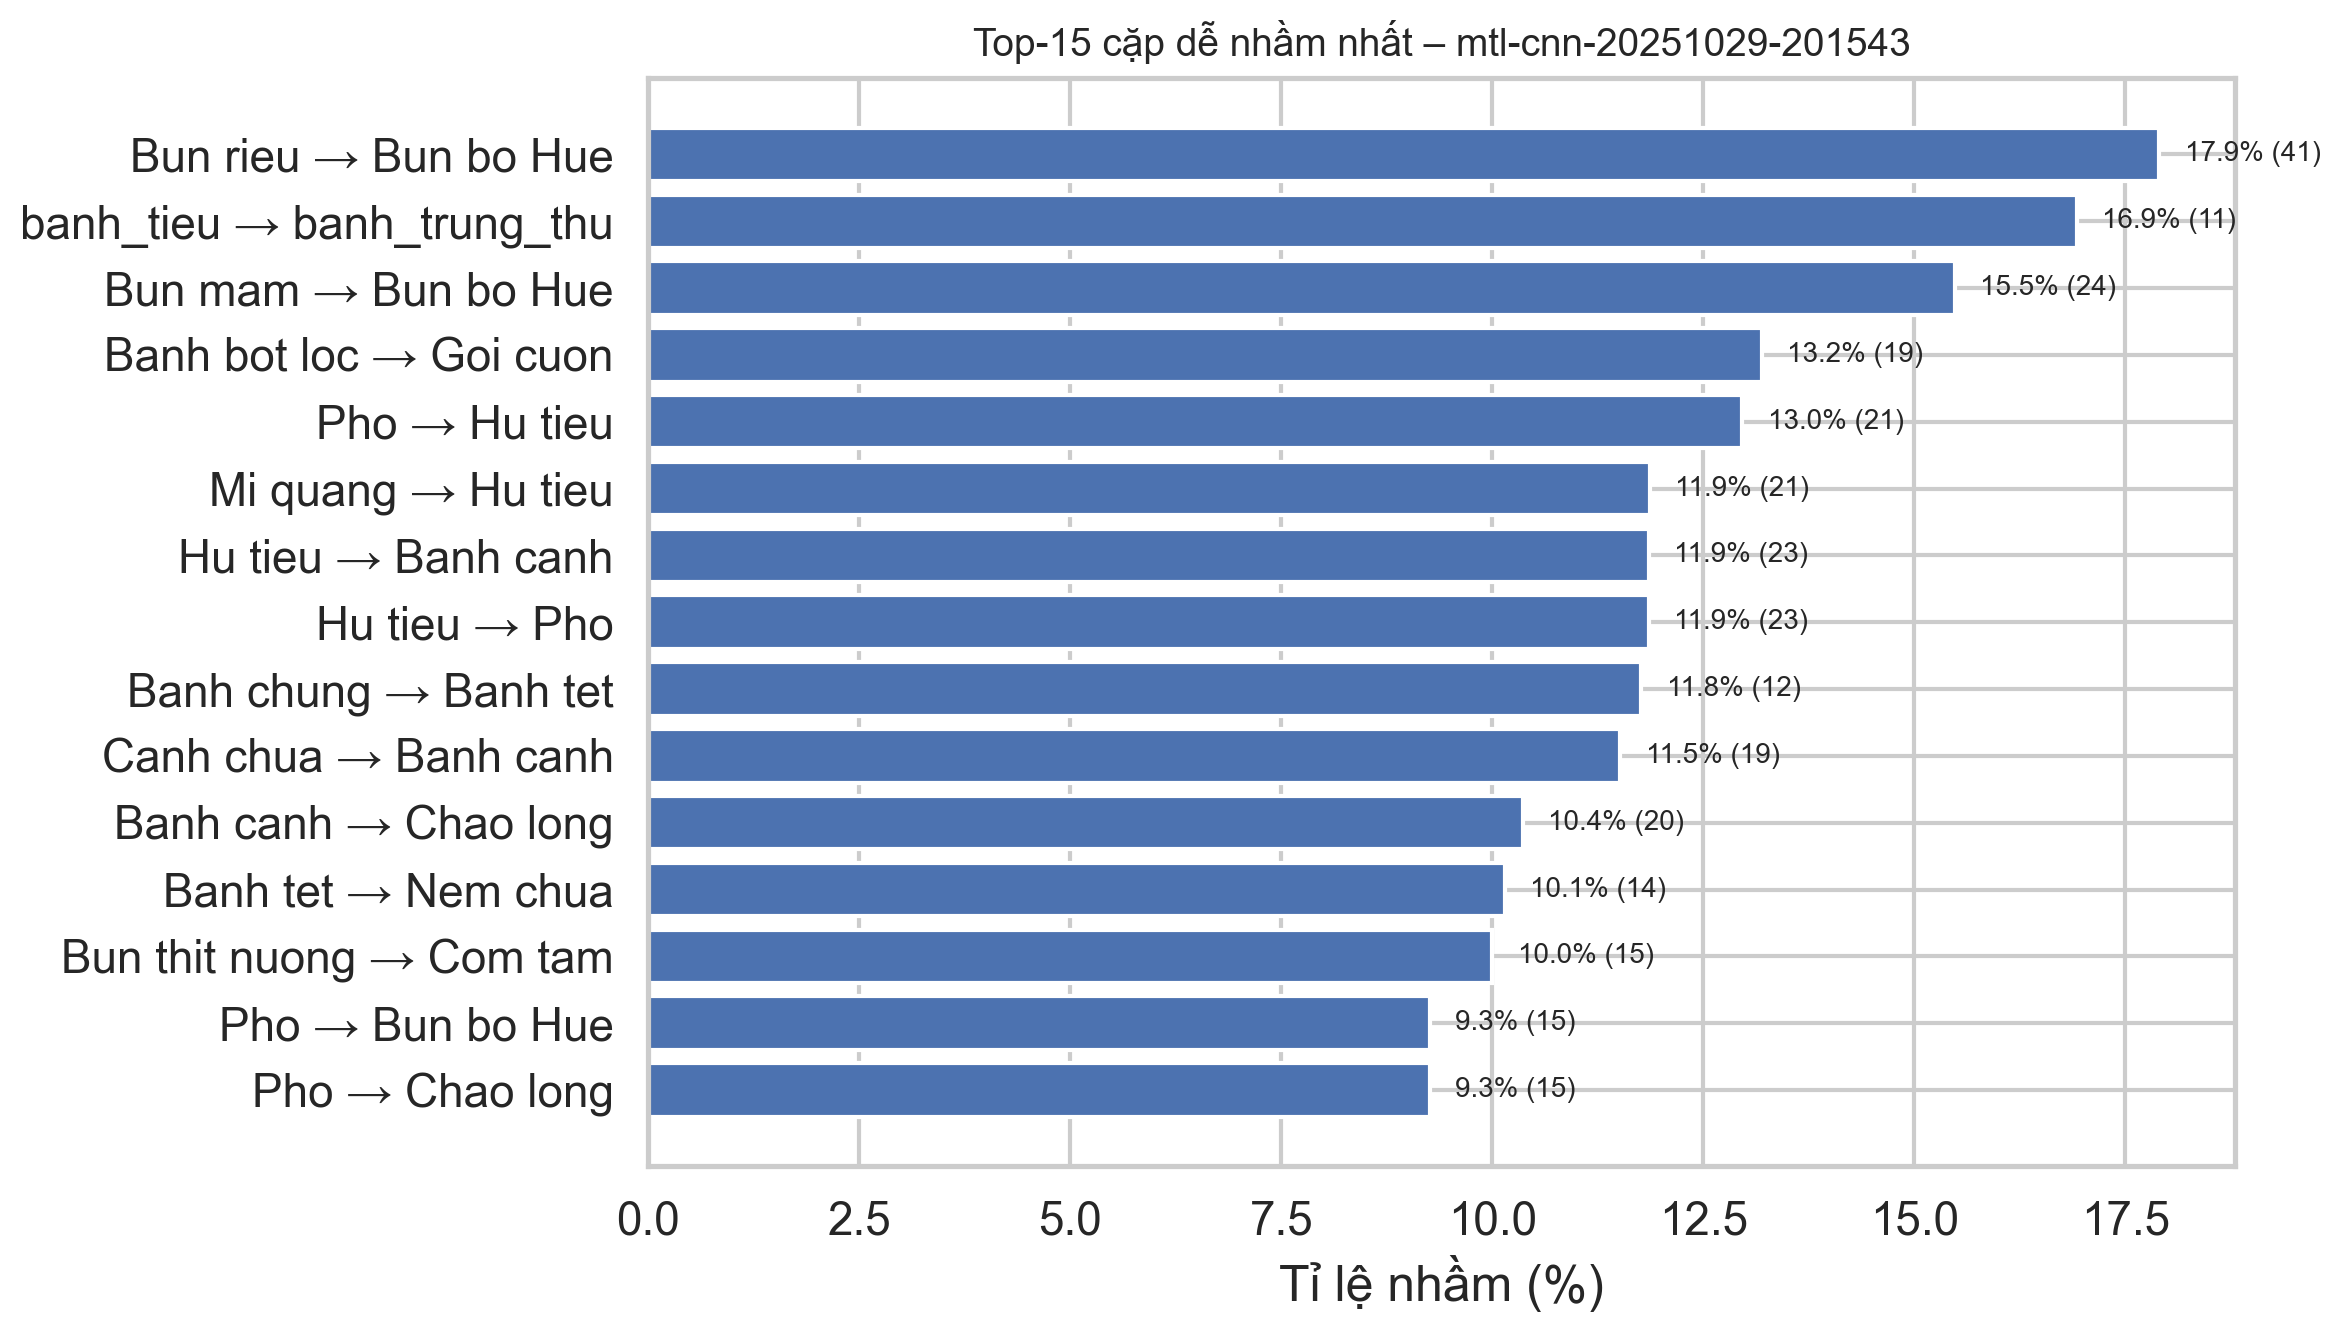

▶️  Đánh giá: mtl-efficientnet_b0-20251029-233246


C:\Users\Admin\AppData\Local\Temp\ipykernel_31584\3133259203.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


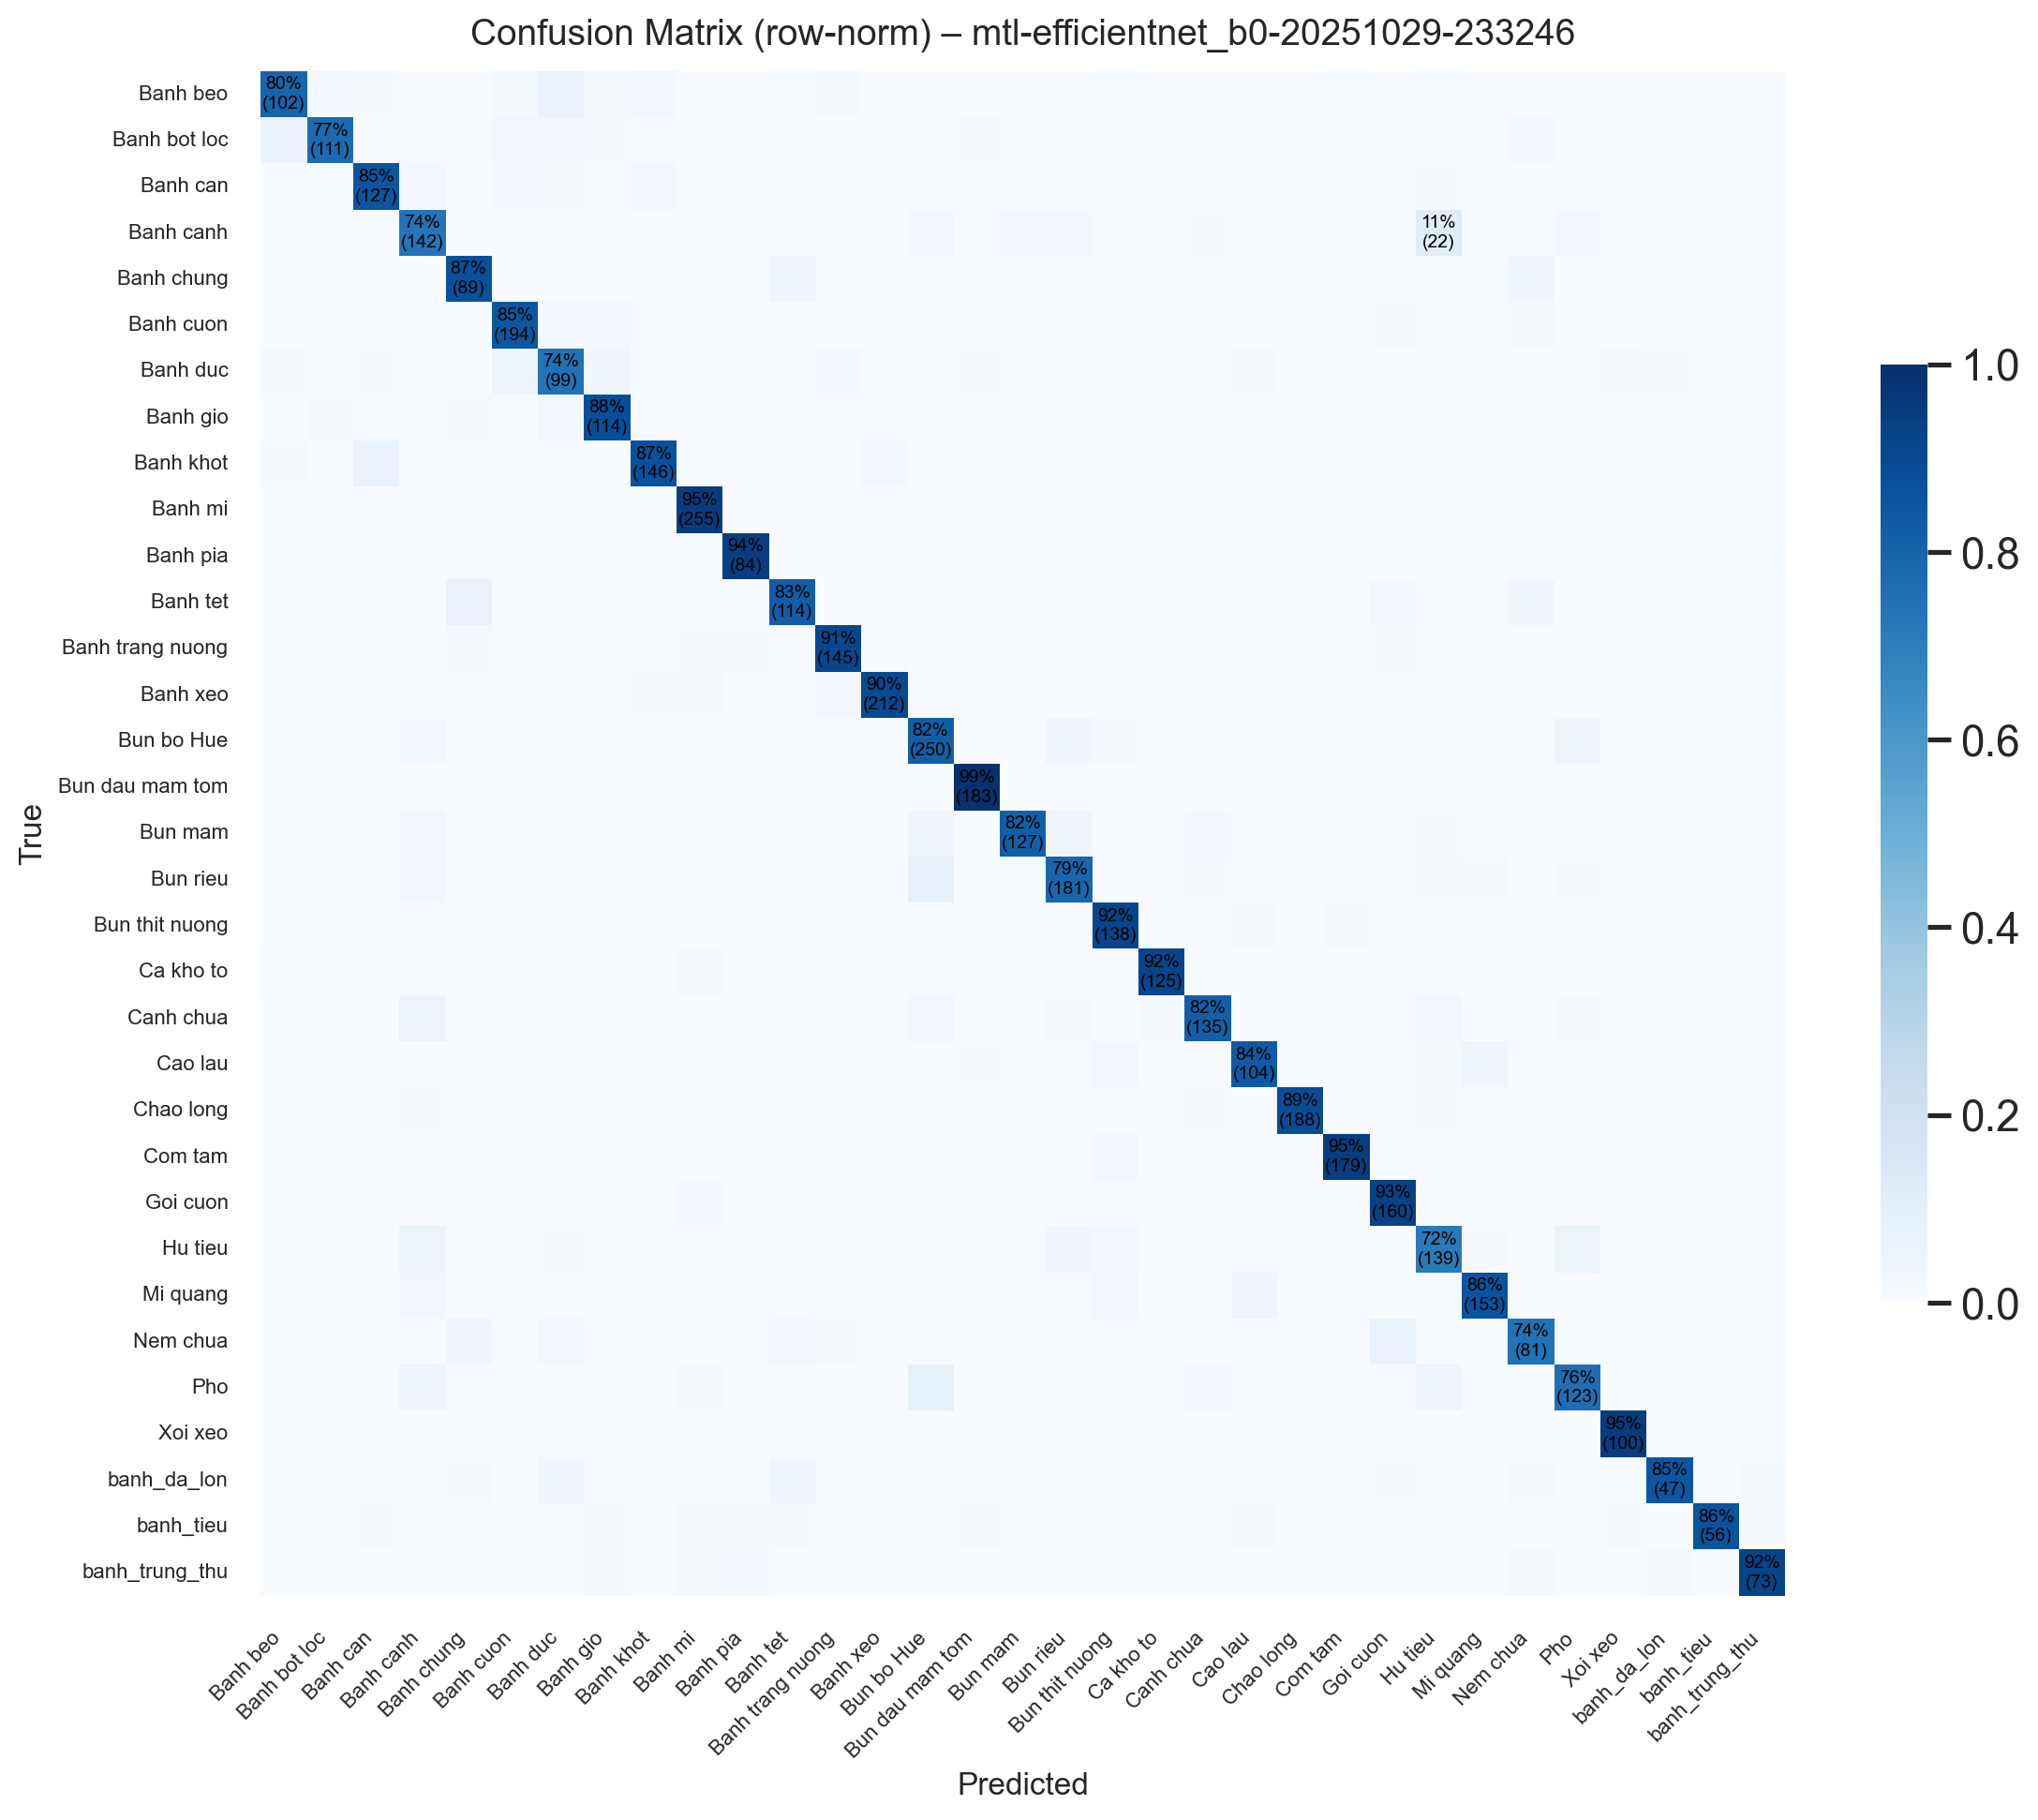

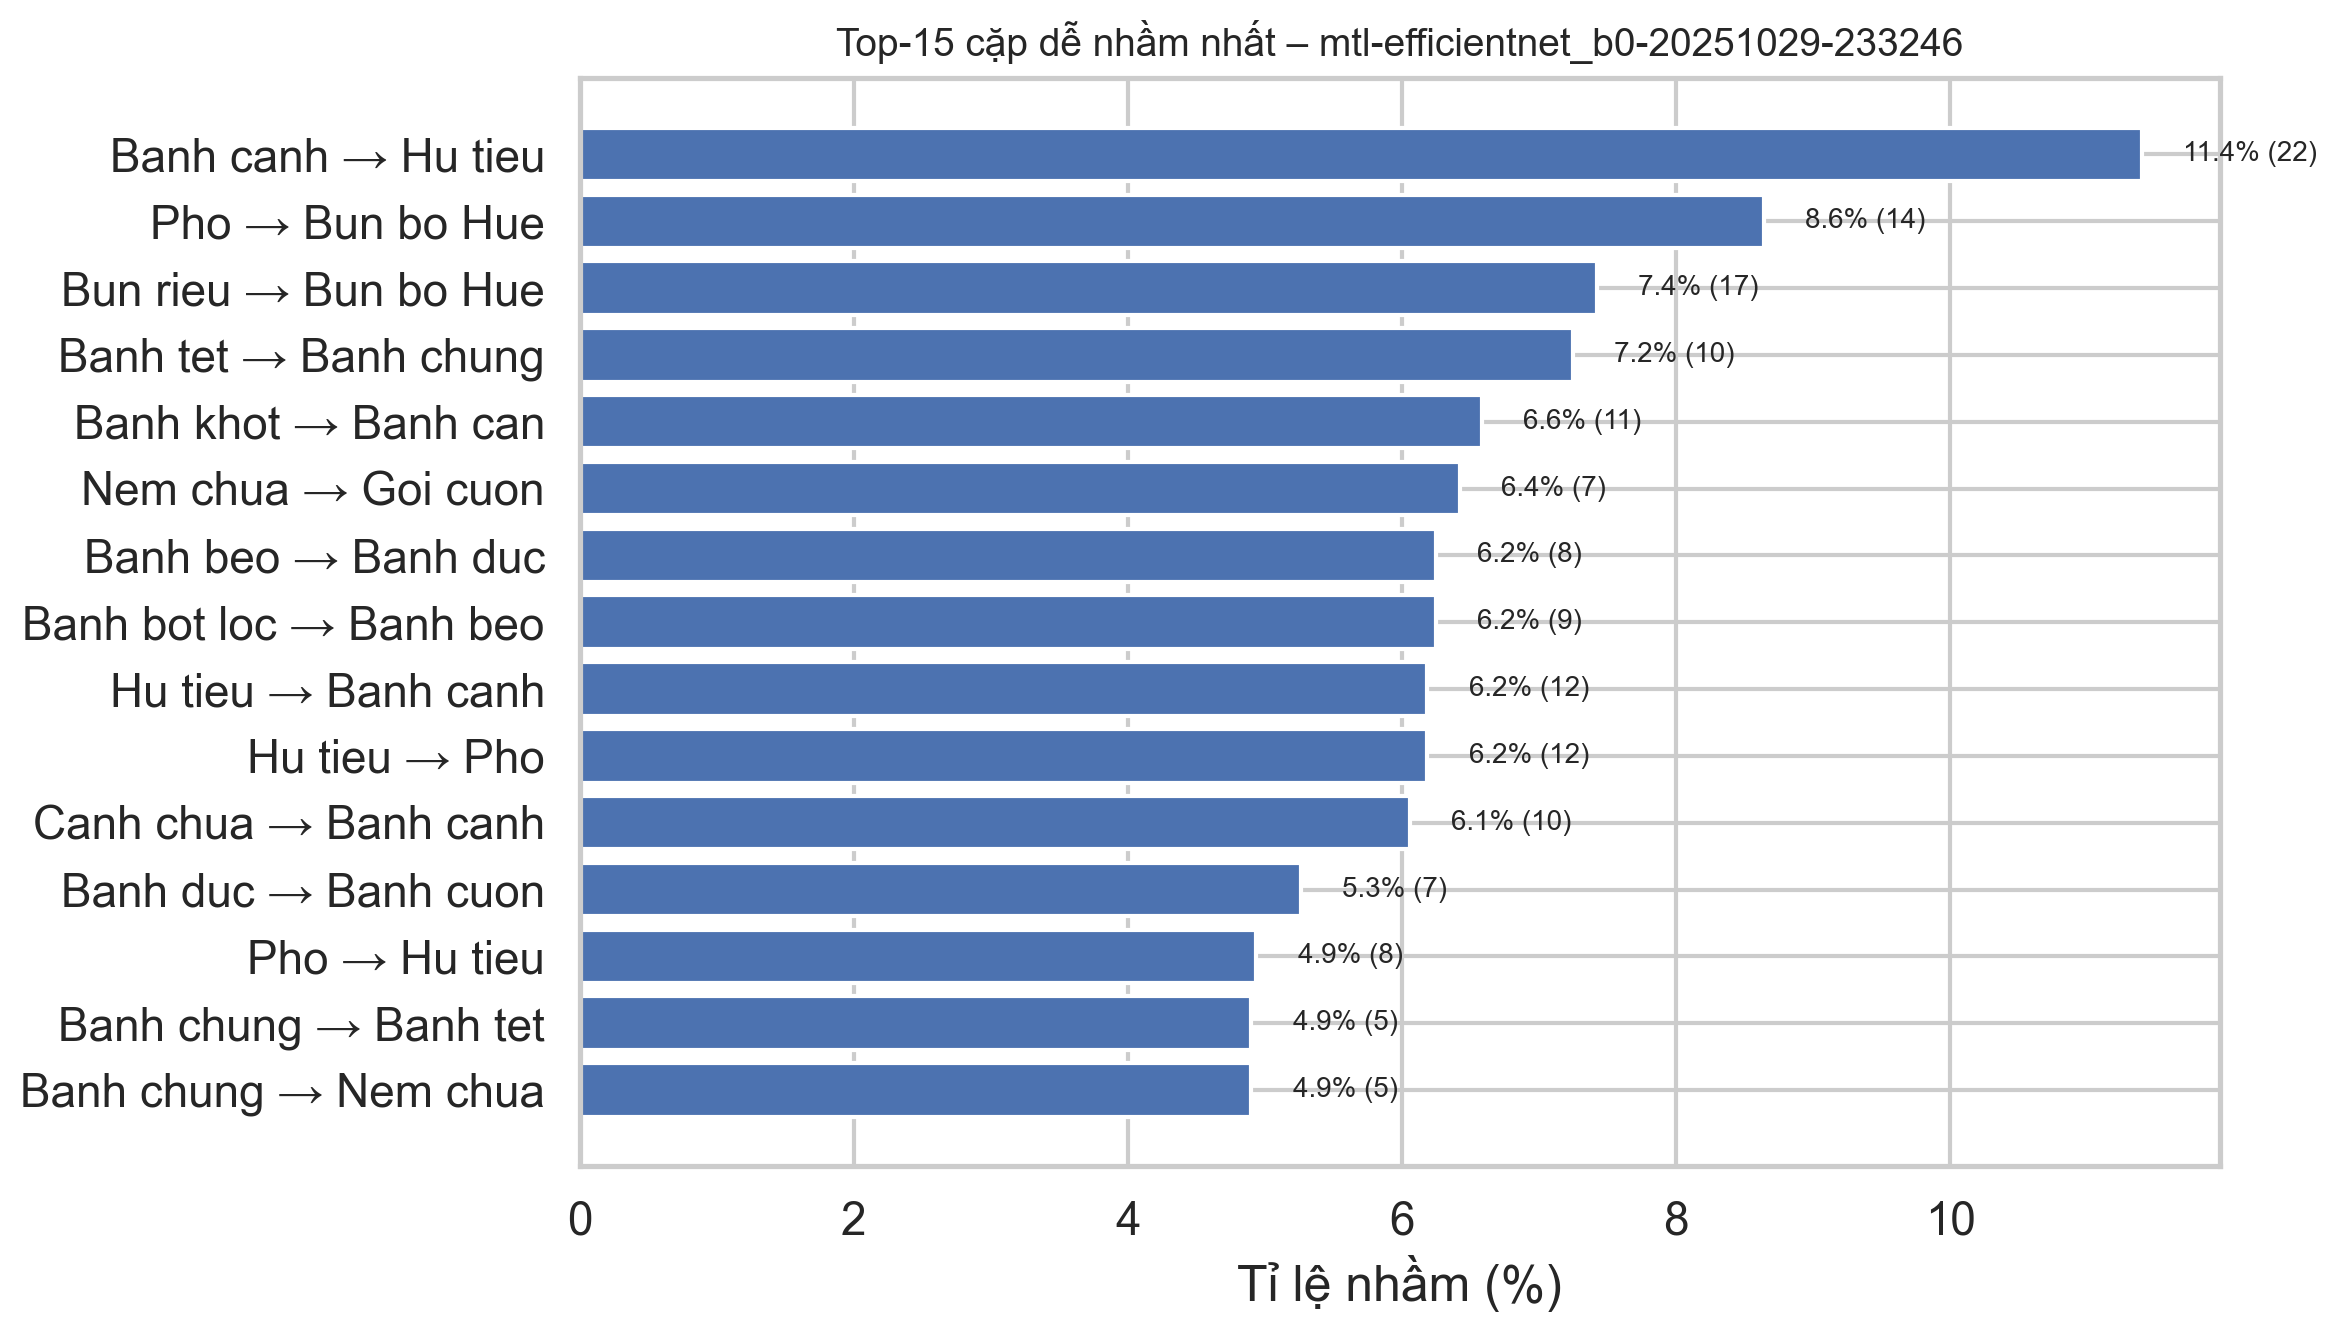

▶️  Đánh giá: mtl-mobilenetv4-20251029-223758


C:\Users\Admin\AppData\Local\Temp\ipykernel_31584\3133259203.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


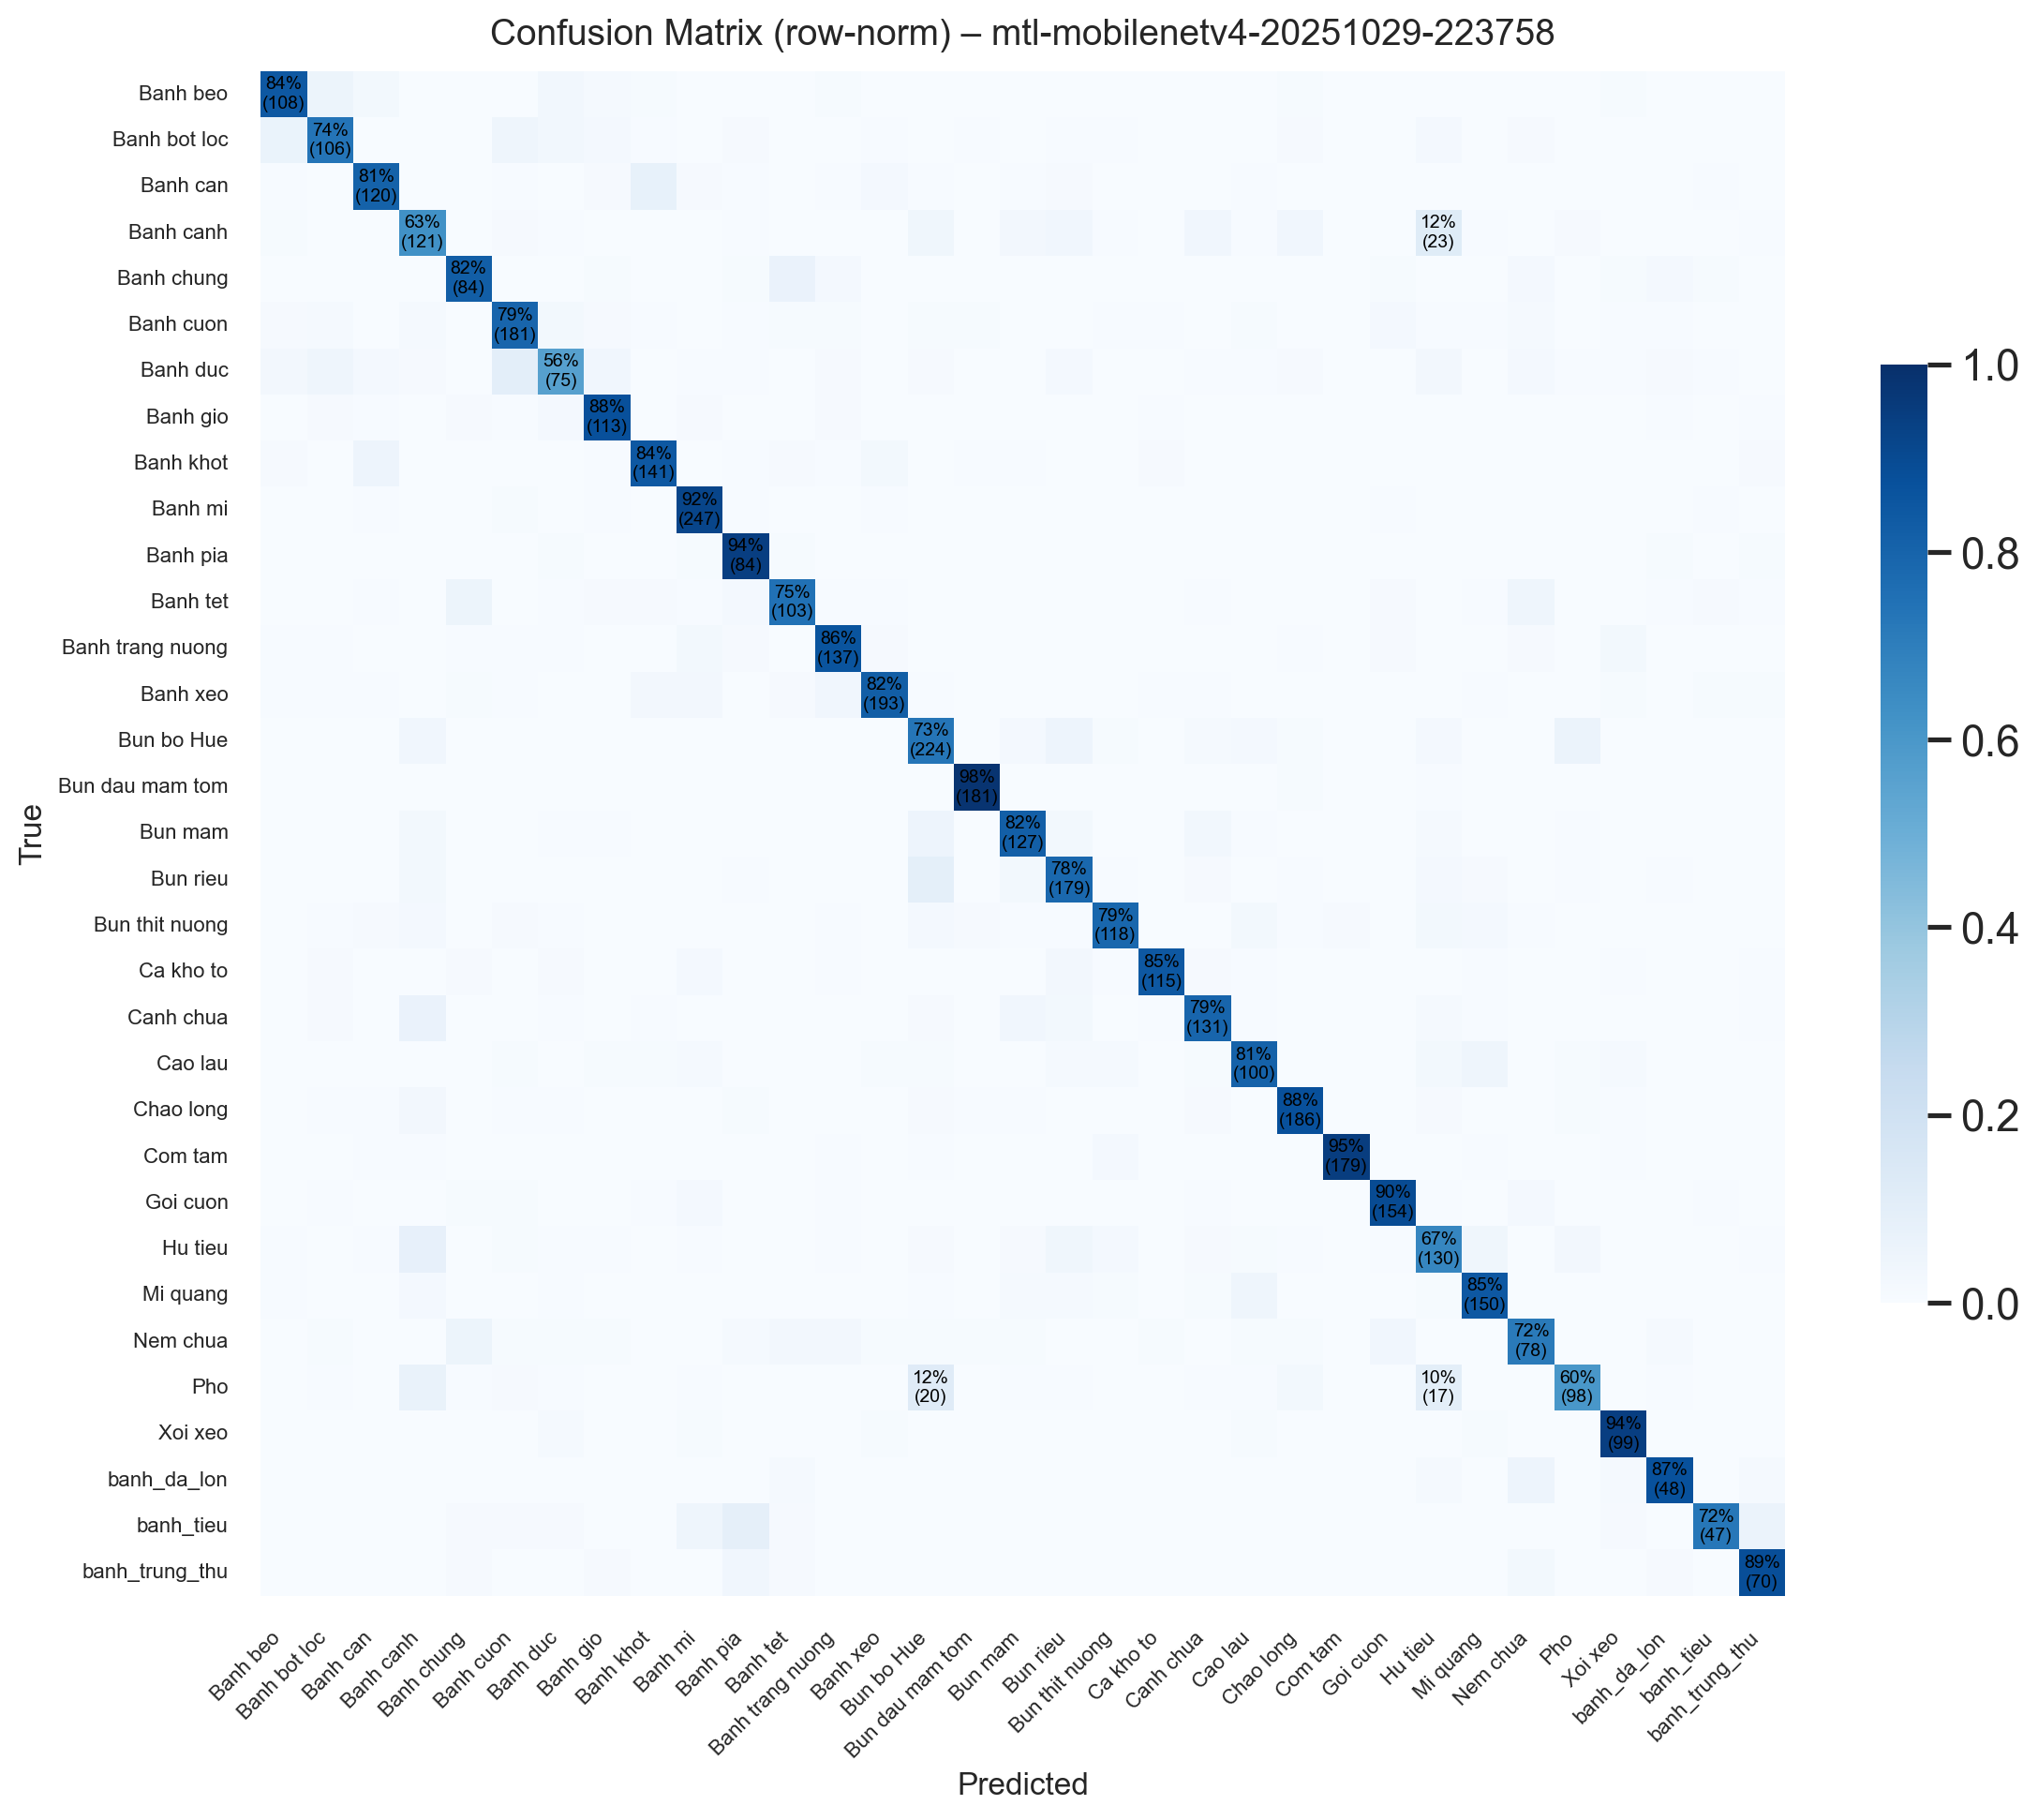

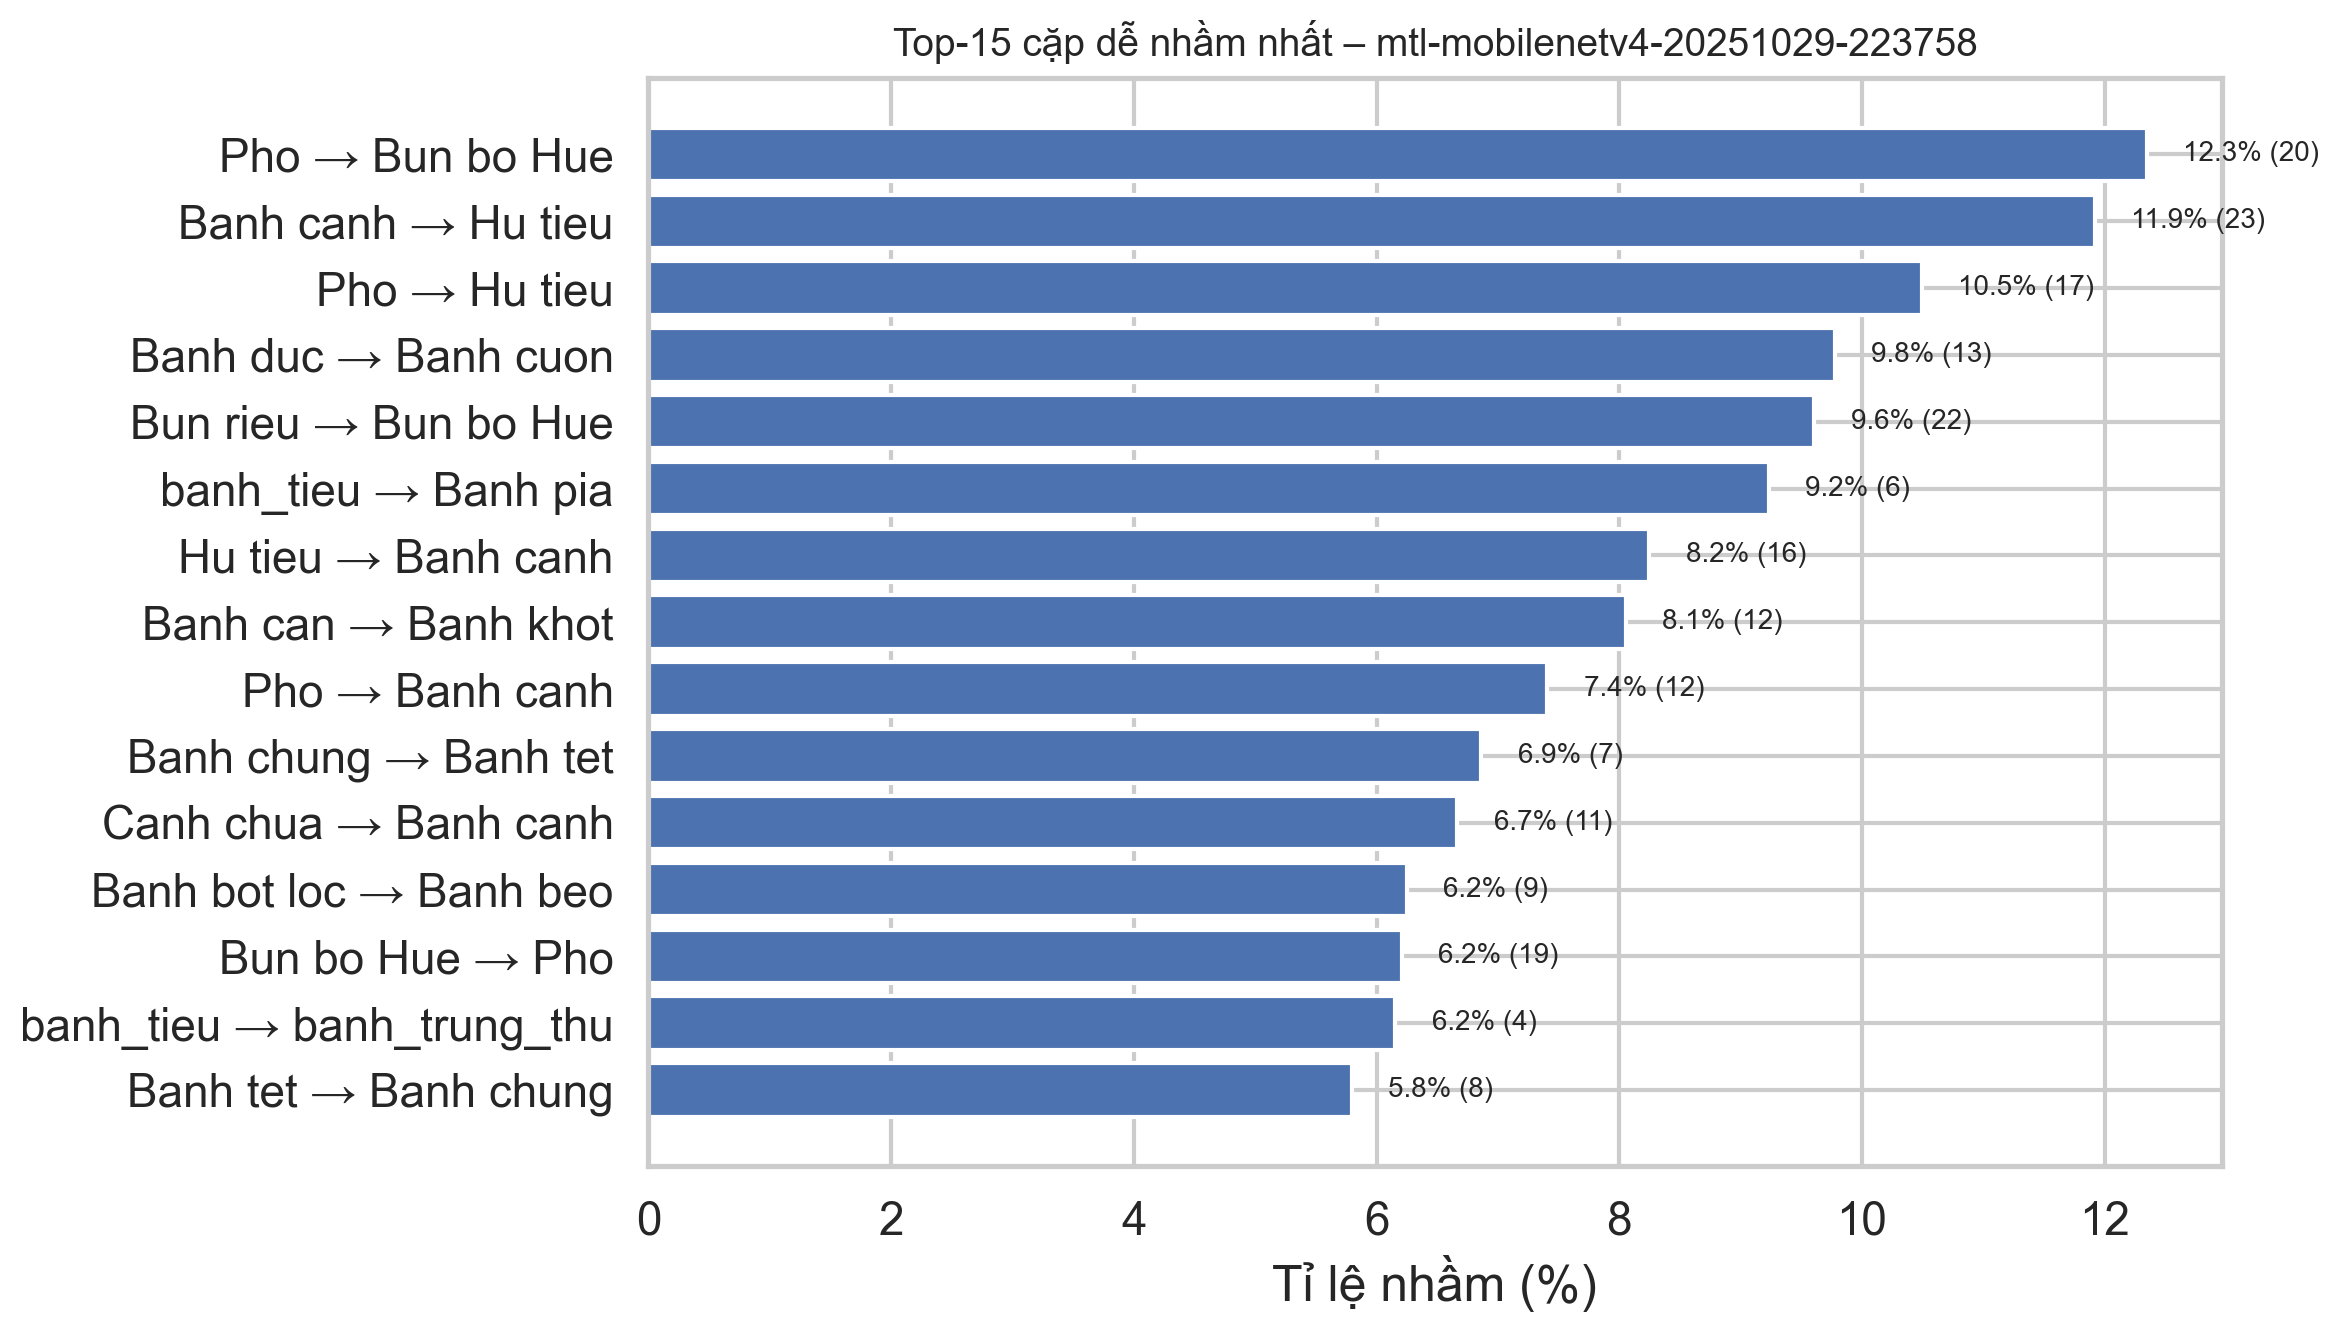

run       acc  precision    recall  \
1  mtl-efficientnet_b0-20251029-233246  0.855832   0.857955  0.855832   
2      mtl-mobilenetv4-20251029-223758  0.808222   0.809629  0.808222   
0              mtl-cnn-20251029-201543  0.438432   0.442125  0.438432   

         f1  img_size  batch_size      ckpt  
1  0.856065       224          64  last.mtl  
2  0.807688       224          64  last.mtl  
0  0.436983       224          64  last.mtl

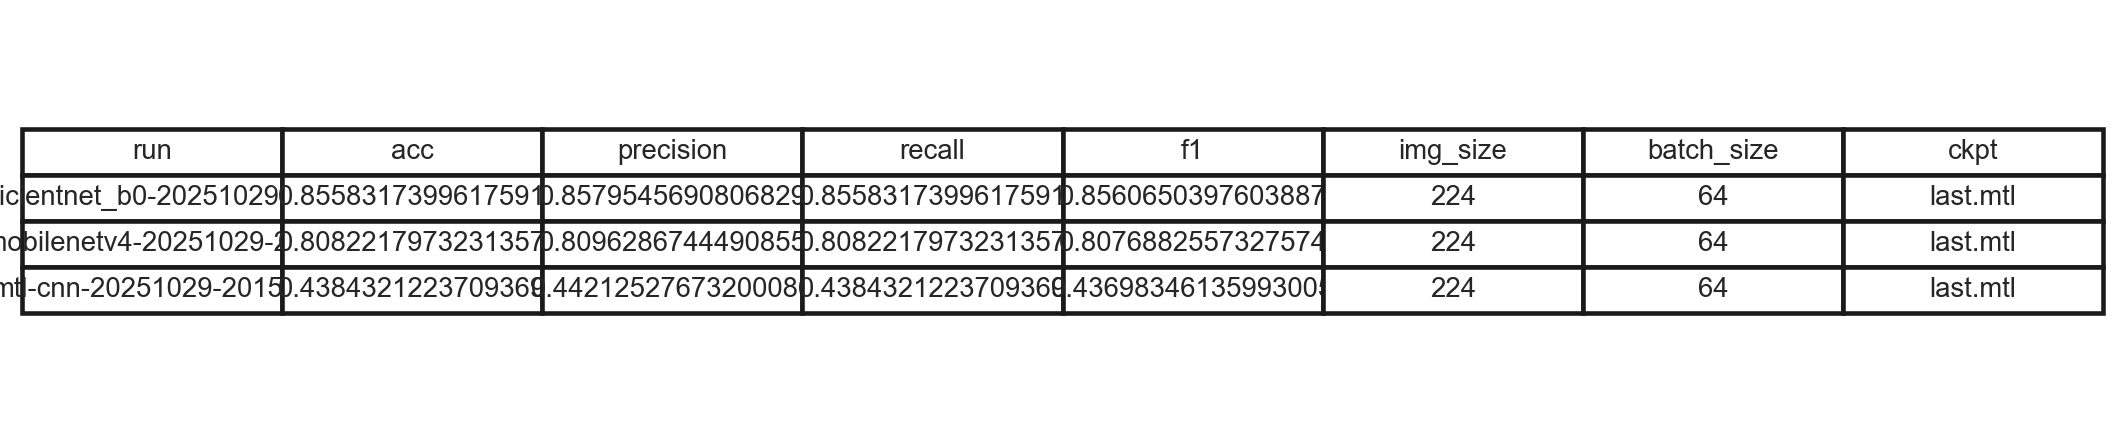

✅ Lưu: images\summary_models.png


In [239]:

# ==== CELL 6: EVALUATE ALL RUNS & RANKING (robust loader tuple) ====
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

RUNS_DIR   = "Runs"
IMAGES_DIR = "images"
os.makedirs(IMAGES_DIR, exist_ok=True)

# Dùng lại class_names đã nạp ở cell trước; nếu chưa có thì thử đọc file dự phòng
if "class_names" not in globals():
    # nếu bạn đã có file class_names.json dưới ROOT thì mở ra
    fallback_json = os.path.join(ROOT, "class_names.json")
    if os.path.isfile(fallback_json):
        class_names = json.load(open(fallback_json, "r", encoding="utf-8"))
    else:
        raise RuntimeError("Bạn chưa nạp class_names. Hãy chạy cell nạp class_names hoặc cung cấp file class_names.json.")

NUM_CLASSES = len(class_names)

# Cache để Cell ROC nhiều model
if "ROC_CACHE" not in globals():
    ROC_CACHE = []

def load_run_config(run_path, default_img=224, default_bs=64):
    cfg_path = os.path.join(run_path, "config.json")
    img, bs = default_img, default_bs
    if os.path.isfile(cfg_path):
        try:
            cfg = json.load(open(cfg_path, "r", encoding="utf-8"))
            img = int(cfg.get("img_size", cfg.get("IMG_SIZE", img)))
            bs  = int(cfg.get("batch_size", cfg.get("BATCH_SIZE", bs)))
        except Exception:
            pass
    return img, bs

def create_test_transform(img_size):
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

def pick_checkpoint(run_path):
    ckpt_dir = os.path.join(run_path, "checkpoints")
    cands = []
    for d in [ckpt_dir, run_path]:
        if not os.path.isdir(d): 
            continue
        for fn in os.listdir(d):
            if fn.lower().endswith((".mtl", ".pt", ".pth")):
                cands.append(os.path.join(d, fn))
    if not cands: 
        return None
    mtls = [p for p in cands if p.lower().endswith(".mtl")]
    return sorted(mtls or cands, key=os.path.getmtime)[-1]

def normalize_loader_tuple(loader_out):
    """
    Trả về: (test_loader, ds_class_to_idx)
    - Chấp nhận build_test_loader trả về DataLoader hoặc tuple (loader, class_to_idx) / (loader, idx2name)...
    """
    ds_class_to_idx = None
    if isinstance(loader_out, tuple):
        # phần tử đầu chắc chắn là loader
        test_loader = loader_out[0]
        # cố tìm dict ánh xạ lớp trong các phần tử còn lại
        for item in loader_out[1:]:
            if isinstance(item, dict):
                # nếu là class_to_idx: key là tên lớp (str), value là int
                if all(isinstance(k, str) for k in item.keys()) and all(isinstance(v, int) for v in item.values()):
                    ds_class_to_idx = item
                    break
                # nếu là idx2name: key int, value str -> đảo lại
                if all(isinstance(k, int) for k in item.keys()) and all(isinstance(v, str) for v in item.values()):
                    ds_class_to_idx = {v: k for k, v in item.items()}
                    break
    else:
        test_loader = loader_out

    # fallback lấy từ dataset
    if ds_class_to_idx is None:
        ds_class_to_idx = getattr(getattr(test_loader, "dataset", object()), "class_to_idx", {})
        if not isinstance(ds_class_to_idx, dict):
            ds_class_to_idx = {}

    return test_loader, ds_class_to_idx

def evaluate_model_at(run_path, run_name):
    # 1) đọc config
    img_size, bs = load_run_config(run_path, default_img=224, default_bs=64)
    test_transform = create_test_transform(img_size)

    # 2) build loader (có thể trả về tuple)
    loader_out = build_test_loader(root_test, test_transform, batch_size=bs)
    test_loader, ds_class_to_idx = normalize_loader_tuple(loader_out)

    # 3) remap nhãn nếu thứ tự dataset khác class_names chuẩn
    name2idx = {n: i for i, n in enumerate(class_names)}
    remap = make_remap(ds_class_to_idx, name2idx) if 'make_remap' in globals() else None

    # 4) load checkpoint + model
    ckpt_path = pick_checkpoint(run_path)
    if ckpt_path is None:
        print(f"  ⚠ {run_name}: không tìm thấy checkpoint (.mtl/.pt/.pth) ⇒ bỏ qua.")
        return None
    model = model_auto(run_name)

    model = load_checkpoint(run_name, ckpt_path, device)

    # 5) dự đoán
    y_true, y_pred, y_prob = collect_logits(model, test_loader, device, remap=remap)

    # 6) metrics
    acc = float(accuracy_score(y_true, y_pred))
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)

    # 7) cache cho ROC đa mô hình
    ROC_CACHE.append({
        "name": run_name,
        "y_true": np.asarray(y_true),
        "y_prob": np.asarray(y_prob),
        "class_names": class_names,
    })

    # … (vẽ confusion matrix, top-confusions, lưu ảnh …)  
    #plot_confusion_matrix(y_true, y_pred, class_names, run_name)

    # Confusion matrix
    cm_counts = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    plot_confusion(
        cm_counts, class_names, run_name,
        save_path=f"images/{run_name}_cm.png", row_norm=True, threshold=0.10, dpi=300
    )
    plot_top_confusions(
        cm_counts, class_names, run_name,
        save_path=f"images/{run_name}_topconf.png", topk=15, dpi=300
    )


    return {
        "run": run_name, "acc": acc, "precision": prec, "recall": rec, "f1": f1,
        "img_size": img_size, "batch_size": bs, "ckpt": os.path.basename(ckpt_path)
    }

# ==== quét & đánh giá tất cả runs ====
results = []
if not os.path.isdir(RUNS_DIR):
    print(f"⚠ Thư mục {RUNS_DIR} không tồn tại.")
else:
    for run_name in sorted(os.listdir(RUNS_DIR)):
        run_path = os.path.join(RUNS_DIR, run_name)
        if not os.path.isdir(run_path):
            continue
        print(f"▶️  Đánh giá: {run_name}")
        res = evaluate_model_at(run_path, run_name)
        if res:
            results.append(res)

# ==== bảng xếp hạng & lưu thành ảnh ====
if results:
    df = pd.DataFrame(results).sort_values("acc", ascending=False)
    display(df)

    fig, ax = plt.subplots(figsize=(10, 0.45*len(df)+1), dpi=220)
    ax.axis("off")
    tbl = ax.table(cellText=df.values, colLabels=df.columns, loc="center", cellLoc="center")
    tbl.auto_set_font_size(False); tbl.set_fontsize(9); tbl.scale(1, 1.25)
    plt.tight_layout()
    out_png = os.path.join(IMAGES_DIR, "summary_models.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ Lưu: {out_png}")
else:
    print("⚠ Không có run hợp lệ trong thư mục Runs/")


→ Vẽ lịch sử: mtl-cnn-20251029-201543


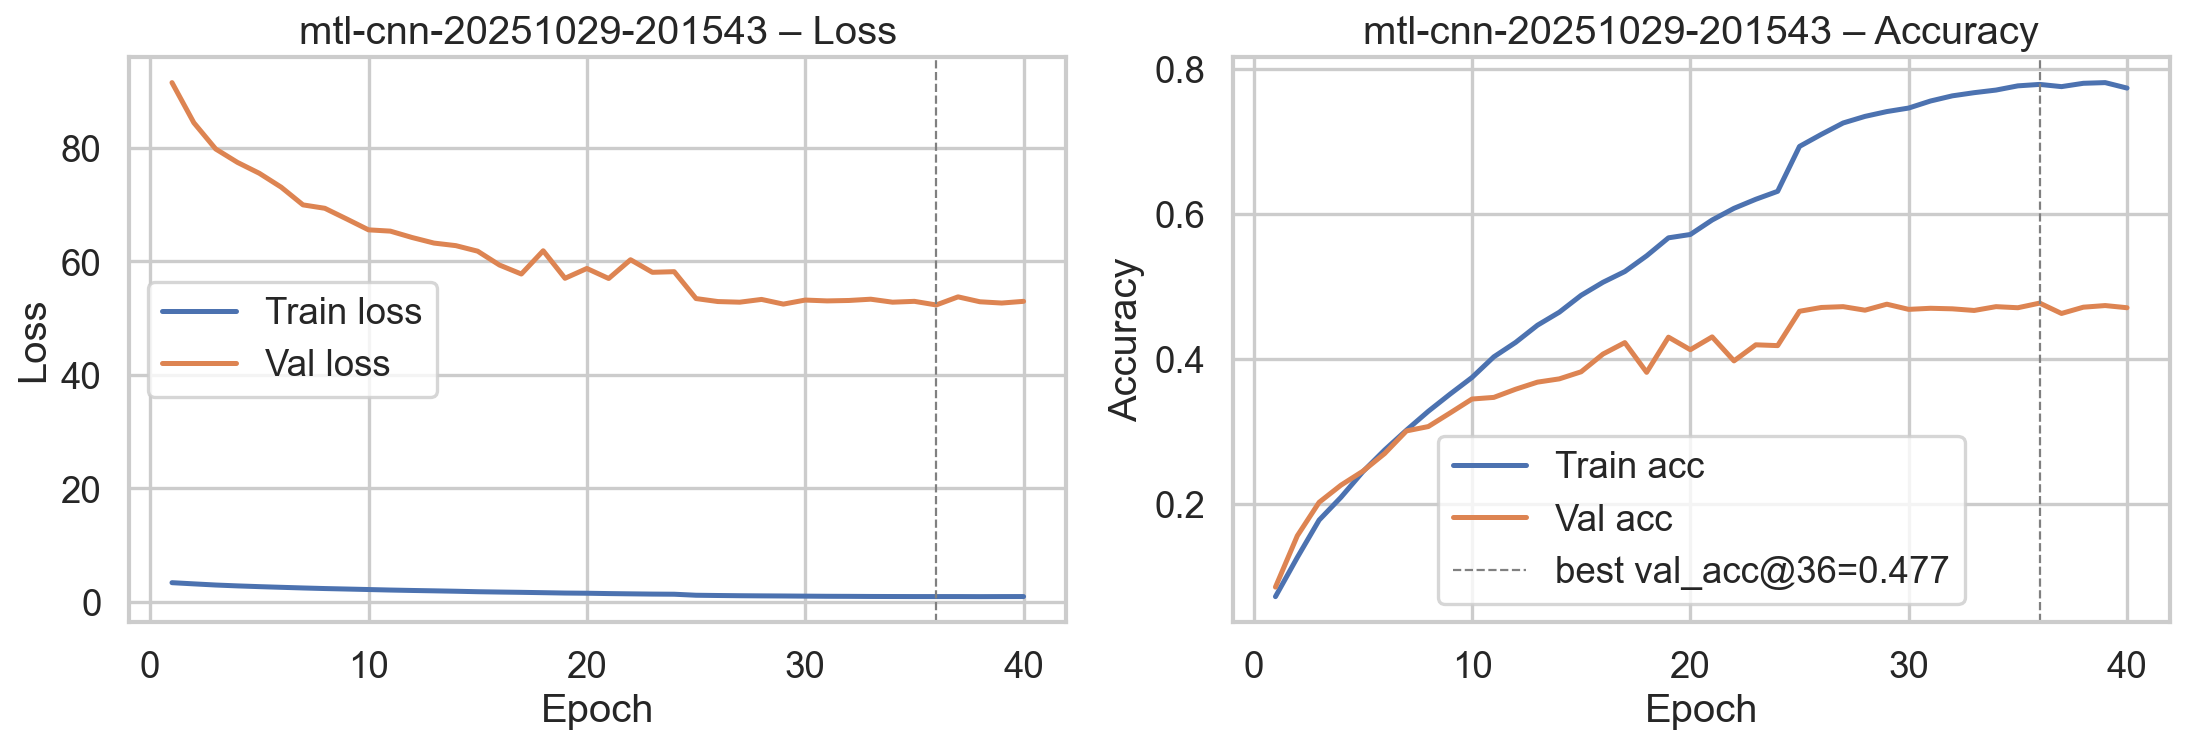

✓ Đã lưu: images\mtl-cnn-20251029-201543_history.png
→ Vẽ lịch sử: mtl-efficientnet_b0-20251029-233246


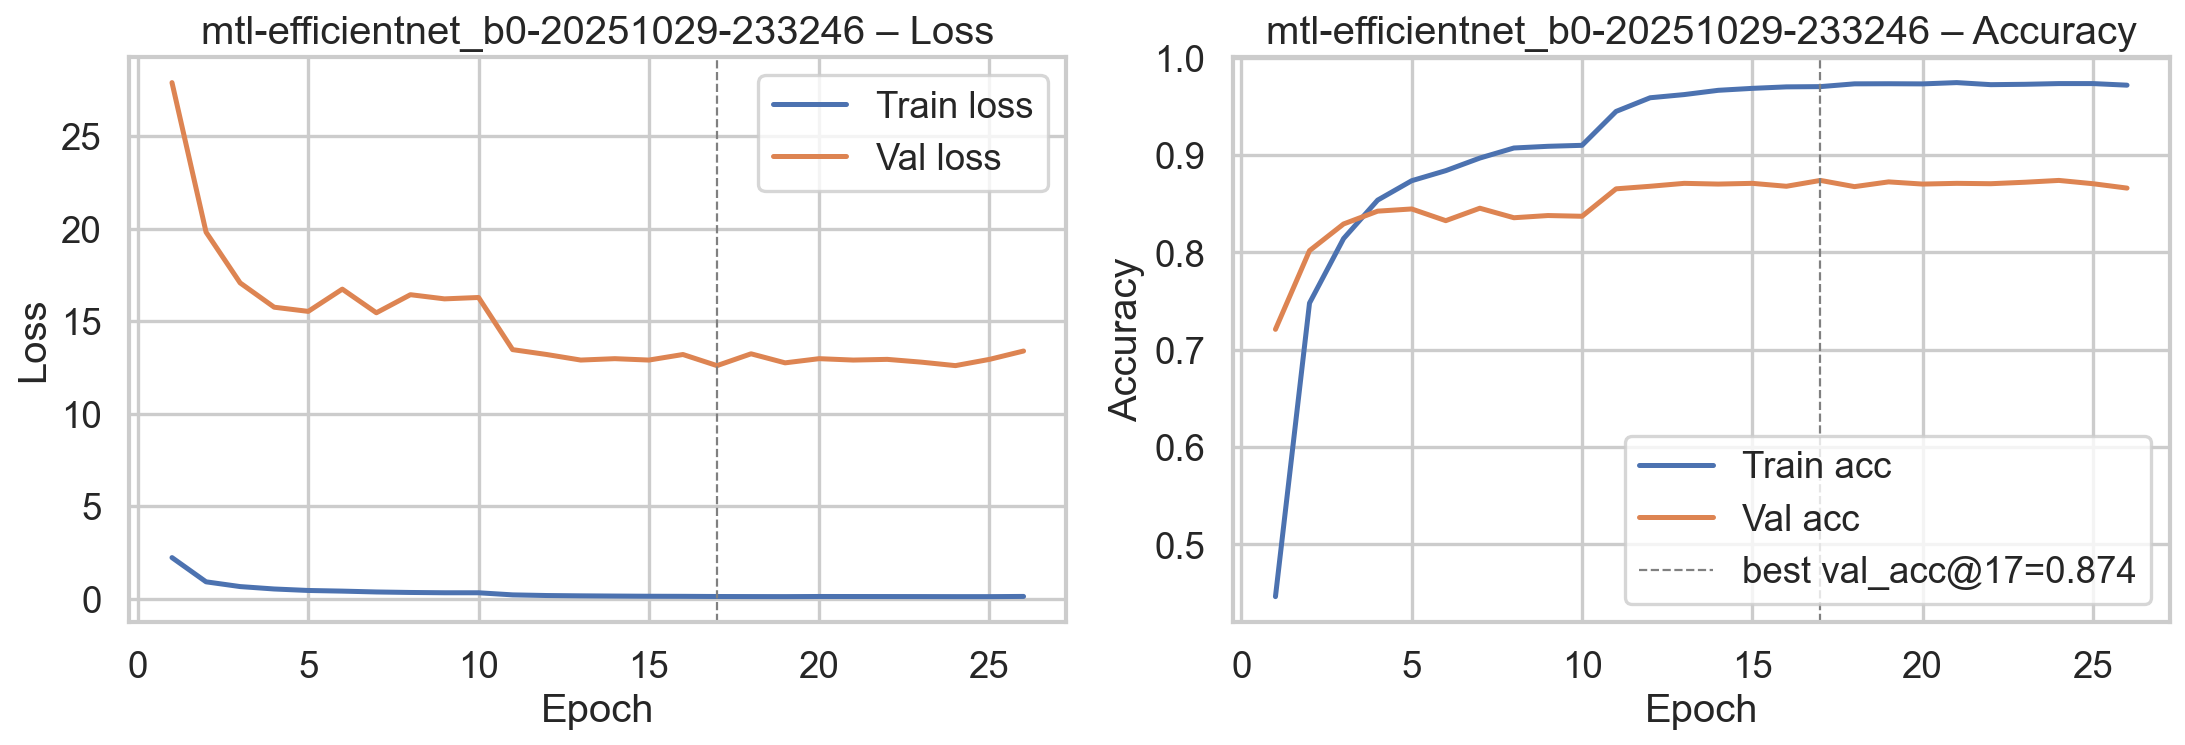

✓ Đã lưu: images\mtl-efficientnet_b0-20251029-233246_history.png
→ Vẽ lịch sử: mtl-mobilenetv4-20251029-223758


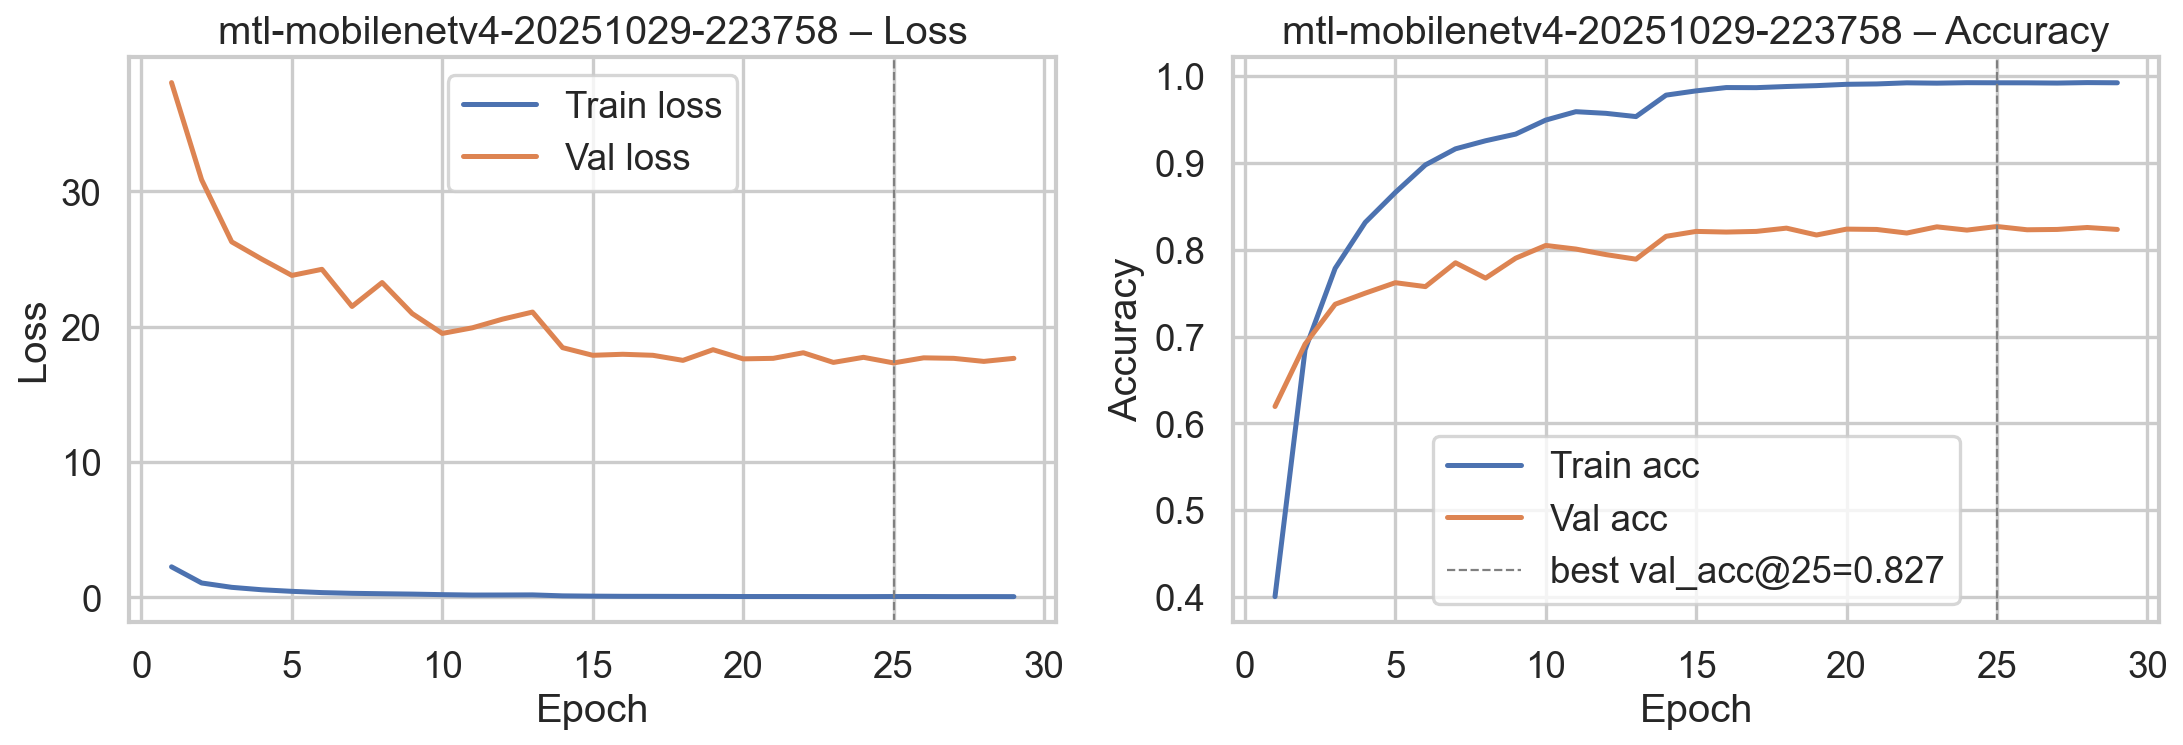

✓ Đã lưu: images\mtl-mobilenetv4-20251029-223758_history.png


In [240]:
# ==== CELL 7 (REPLACE): Vẽ Loss/Accuracy CHO TẤT CẢ CÁC RUNS ====
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RUNS_DIR = "Runs"          # giữ đúng đường dẫn bạn đang dùng
IMAGES_DIR = "images"
os.makedirs(IMAGES_DIR, exist_ok=True)

def pick_col(df, pats):
    """Chọn cột đầu tiên khớp pattern (không phân biệt hoa/thường)."""
    pats = [p.lower() for p in pats]
    for c in df.columns:
        cl = c.lower()
        if any(re.search(p, cl) for p in pats):
            return c
    return None

def plot_history_for_run(run_path, run_name):
    # 1) tìm file log hợp lệ
    for cand in ["history.csv", "history.json", "train_log.csv", "metrics.csv"]:
        hp = os.path.join(run_path, cand)
        if os.path.isfile(hp):
            hist_path = hp
            break
    else:
        print(f"[-] {run_name}: không thấy history.(csv|json)")
        return

    # 2) đọc log và chuẩn hoá cột
    if hist_path.endswith(".json"):
        df = pd.read_json(hist_path)
    else:
        df = pd.read_csv(hist_path)
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    # 3) epoch thực tế trong file; nếu không có cột epoch thì mặc định 1..len
    c_epoch = pick_col(df, [r"^epoch$", r"^epochs?$"])
    epoch = df[c_epoch].to_numpy() if c_epoch else np.arange(1, len(df)+1)

    # 4) bắt các cột loss/acc “mềm”
    c_tr_loss = pick_col(df, [r"^loss$", r"train.*loss"])
    c_va_loss = pick_col(df, [r"val.*loss", r"valid.*loss"])
    c_tr_acc  = pick_col(df, [r"^acc$", r"accuracy$", r"train.*acc", r"train.*accuracy"])
    c_va_acc  = pick_col(df, [r"val.*acc", r"val.*accuracy", r"valid.*acc", r"valid.*accuracy"])

    tr_loss = df[c_tr_loss].to_numpy() if c_tr_loss else None
    va_loss = df[c_va_loss].to_numpy() if c_va_loss else None
    tr_acc  = df[c_tr_acc].to_numpy()  if c_tr_acc  else None
    va_acc  = df[c_va_acc].to_numpy()  if c_va_acc  else None

    # 5) epoch tốt nhất để annotate
    best_ep, note = None, ""
    if va_acc is not None and len(va_acc) > 0:
        best_ep = int(epoch[np.nanargmax(va_acc)])
        note = f"best val_acc@{best_ep}={np.nanmax(va_acc):.3f}"
    elif va_loss is not None and len(va_loss) > 0:
        best_ep = int(epoch[np.nanargmin(va_loss)])
        note = f"best val_loss@{best_ep}={np.nanmin(va_loss):.3f}"

    # 6) vẽ 2 subplot
    fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=160)

    # Loss
    if tr_loss is not None: ax[0].plot(epoch, tr_loss, label="Train loss")
    if va_loss is not None: ax[0].plot(epoch, va_loss, label="Val loss")
    if best_ep is not None: ax[0].axvline(best_ep, ls="--", lw=1, c="gray")
    ax[0].set_title(f"{run_name} – Loss")
    ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss"); ax[0].legend()

    # Accuracy
    if tr_acc is not None: ax[1].plot(epoch, tr_acc, label="Train acc")
    if va_acc is not None: ax[1].plot(epoch, va_acc, label="Val acc")
    if best_ep is not None:
        ax[1].axvline(best_ep, ls="--", lw=1, c="gray", label=note if va_acc is not None else None)
    ax[1].set_title(f"{run_name} – Accuracy")
    ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Accuracy"); ax[1].legend()

    plt.tight_layout()
    out_png = os.path.join(IMAGES_DIR, f"{run_name}_history.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✓ Đã lưu: {out_png}")

# 🔁 DUYỆT HẾT TẤT CẢ RUNS và vẽ
if not os.path.isdir(RUNS_DIR):
    print(f"Thư mục '{RUNS_DIR}' không tồn tại.")
else:
    for run_name in sorted(os.listdir(RUNS_DIR)):
        run_path = os.path.join(RUNS_DIR, run_name)
        if not os.path.isdir(run_path):
            continue


      

        print(f"→ Vẽ lịch sử: {run_name}")
        plot_history_for_run(run_path, run_name)


In [241]:
# ==== CELL 8A: PHÂN TÍCH MÔ HÌNH CHUYÊN SÂU ====
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import torch

IMAGES_DIR = "images"
os.makedirs(IMAGES_DIR, exist_ok=True)

# Đảm bảo có class_names và test_loader (đã build ở Cell 3)
assert "class_names" in globals(), "⚠️ Cần nạp class_names trước Cell 8!"
assert "test_loader" in globals(), "⚠️ Cần build test_loader trước Cell 8!"


In [242]:
# CELL 8B: Biểu đồ ROC Curve & AUC (multi-class, one-vs-rest)
def plot_roc_auc_for_model(run_name, y_true, y_prob, class_names):
    """
    Vẽ ROC & tính AUC trung bình cho mô hình đa lớp.
    y_true:  nhãn thật (int)
    y_prob:  xác suất softmax [N, num_classes]
    """
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    # ROC & AUC từng lớp
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # AUC trung bình
    macro_auc = roc_auc_score(y_true_bin, y_prob, average="macro")
    print(f"→ {run_name}: macro AUC = {macro_auc:.4f}")

    # Vẽ 5 lớp đầu để tránh rối
    plt.figure(figsize=(7, 6), dpi=140)
    for i, cname in enumerate(class_names[:5]):
        plt.plot(fpr[i], tpr[i], label=f"{cname} (AUC = {roc_auc[i]:.3f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.title(f"ROC Curves – {run_name}\nMacro AUC = {macro_auc:.3f}")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(fontsize=8); plt.tight_layout()
    out_png = os.path.join(IMAGES_DIR, f"{run_name}_roc_auc.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Đã lưu:", out_png)


In [243]:
# (C) Tốc độ & hiệu năng Inferencing
import time

def benchmark_model(model, device, input_size=(1, 3, 224, 224), repeat=30):
    """
    Đo thời gian infer (Forward pass) và ước tính FPS trên batch 1.
    """
    x = torch.randn(input_size).to(device)
    model.eval()

    with torch.no_grad():
        # warm-up
        for _ in range(5):
            _ = model(x)
        if device.type == "cuda":
            torch.cuda.synchronize()

        t0 = time.time()
        for _ in range(repeat):
            _ = model(x)
        if device.type == "cuda":
            torch.cuda.synchronize()
        t1 = time.time()

    avg = (t1 - t0) / repeat
    fps = 1 / avg
    params = sum(p.numel() for p in model.parameters())
    print(f"⏱️ {model.__class__.__name__}: {avg*1000:.2f} ms/infer ({fps:.1f} FPS) | Params ≈ {params/1e6:.2f} M")
    return avg, fps, params


In [244]:
# ==== CELL 9: ẢNH TEST BỊ NHẦM NHIỀU NHẤT (Top Confused Pairs) ====
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import io

IMAGES_DIR = "images"
os.makedirs(IMAGES_DIR, exist_ok=True)

def show_top_confused_pairs(model, test_loader, class_names, run_name, device, top_k=6):
    """
    Hiển thị top K cặp lớp mà model nhầm lẫn nhiều nhất (dựa trên confusion matrix)
    + Kèm ảnh ví dụ thật bị nhầm.
    """
    model.eval()
    y_true, y_pred, paths = [], [], []

    # 🔹 B1: Thu nhãn thật, dự đoán, và đường dẫn ảnh
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            outputs = model(x)
            preds = outputs.argmax(1).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(preds)

            # Nếu dataset có thuộc tính filepaths / samples
            if hasattr(test_loader.dataset, "samples"):
                paths.extend([s[0] for s in test_loader.dataset.samples[len(paths):len(paths)+len(y)]])
            elif hasattr(test_loader.dataset, "imgs"):
                paths.extend([s[0] for s in test_loader.dataset.imgs[len(paths):len(paths)+len(y)]])
            else:
                paths.extend(["(Không có đường dẫn)"] * len(y))

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    cm_counts = confusion_matrix(y_true, y_pred)

    # 🔹 B2: Xác định các cặp bị nhầm nhiều nhất (không lấy đường chéo)
    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                pairs.append((i, j, cm[i, j], cm_counts[i, j]))
    top_pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:top_k]

    # 🔹 B3: Hiển thị từng cặp kèm ảnh minh họa
    fig, axes = plt.subplots(len(top_pairs), 2, figsize=(7, 3 * len(top_pairs)))
    fig.suptitle(f"Ảnh test thực sự bị model nhầm (Top confused pairs) – {run_name}",
                 fontsize=14, fontweight="bold", y=0.995)

    for idx, (i, j, rate, count) in enumerate(top_pairs):
        # Tìm ảnh ví dụ bị nhầm này
        candidates = np.where((y_true == i) & (y_pred == j))[0]
        img_path = paths[candidates[0]] if len(candidates) > 0 else None

        # Cột 1: ảnh minh họa
        ax_img, ax_text = axes[idx]
        ax_img.axis("off")
        if img_path and os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            ax_img.imshow(img)
        else:
            ax_img.text(0.5, 0.5, "Không có ảnh", ha="center", va="center", fontsize=10)

        # Cột 2: thông tin nhầm lẫn
        ax_text.axis("off")
        text = (
            f"Ảnh bị nhầm: {class_names[i]} → {class_names[j]}\n\n"
            f"Tỉ lệ nhầm (CM): {rate*100:.2f}% ({count} mẫu)\n"
            f"True: {class_names[i]}\nPred: {class_names[j]}"
        )
        ax_text.text(0, 0.5, text, va="center", fontsize=11)

    plt.tight_layout()
    out_path = os.path.join(IMAGES_DIR, f"{run_name}_top_confused_pairs.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✓ Đã lưu: {out_path}")


C:\Users\Admin\AppData\Local\Temp\ipykernel_31584\3133259203.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)



=== ĐÁNH GIÁ MÔ HÌNH mtl-cnn-20251029-201543 ===
→ mtl-cnn-20251029-201543: macro AUC = 0.9125


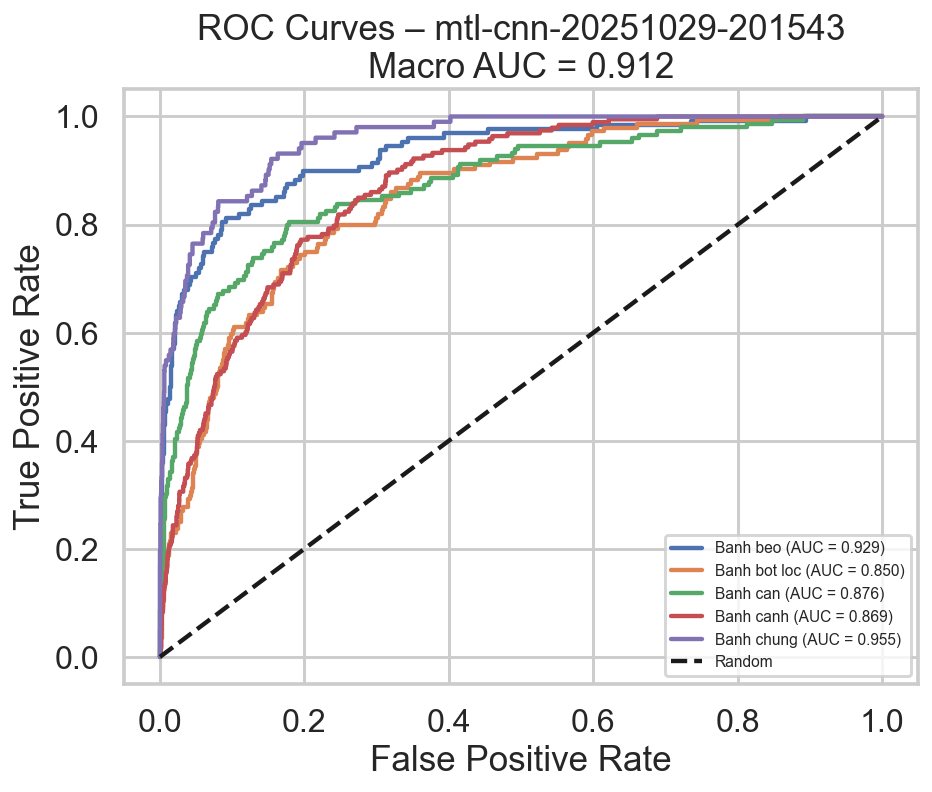

✓ Đã lưu: images\mtl-cnn-20251029-201543_roc_auc.png


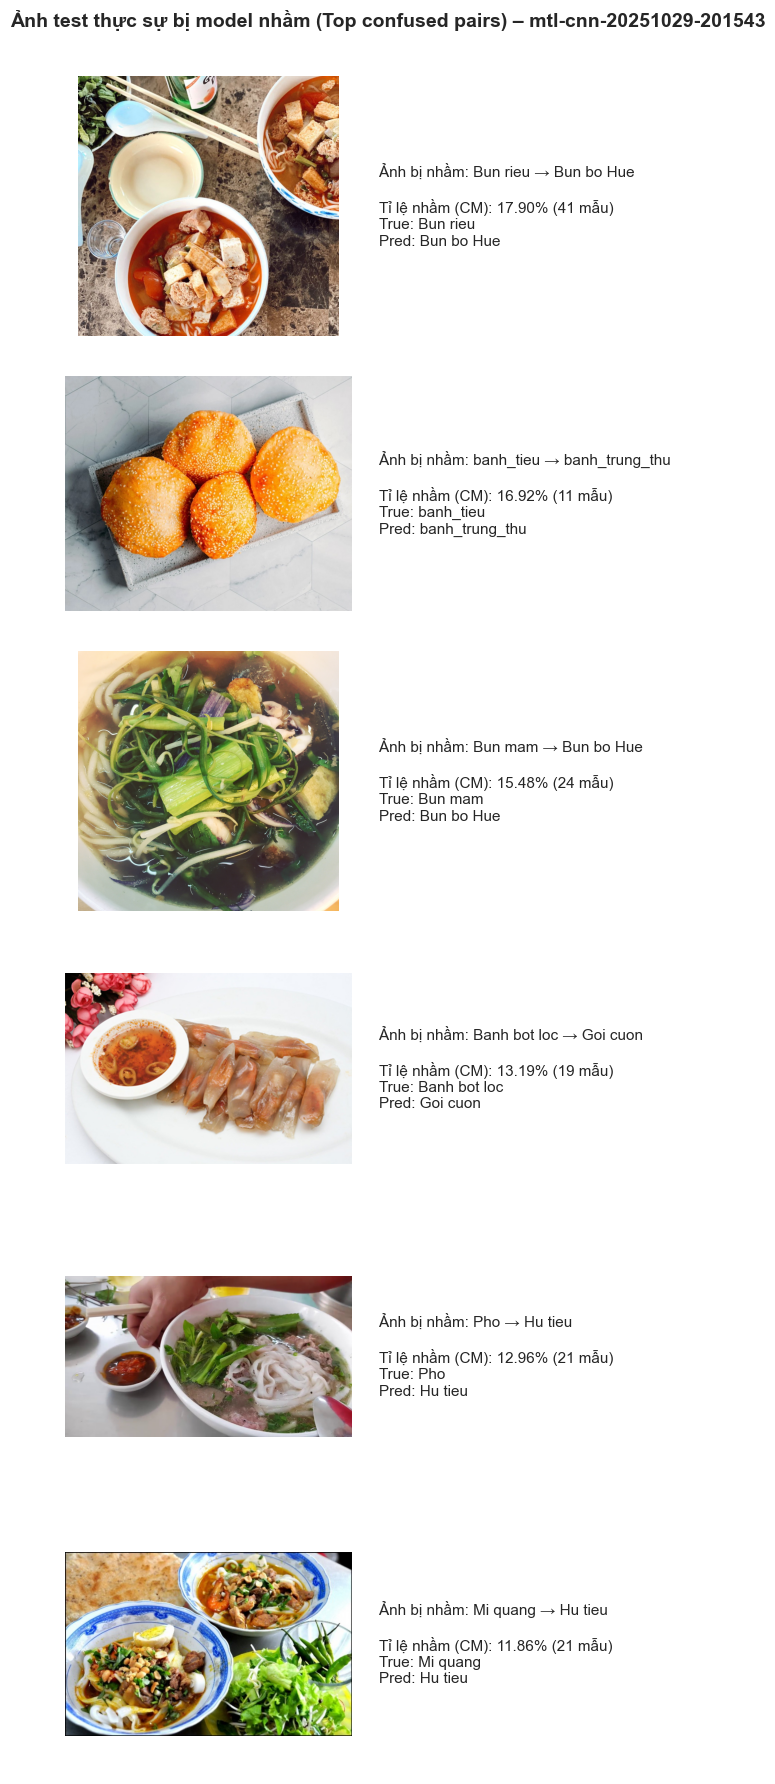

✓ Đã lưu: images\mtl-cnn-20251029-201543_top_confused_pairs.png
⏱️ CustomMobileNet: 4.53 ms/infer (220.8 FPS) | Params ≈ 3.24 M


C:\Users\Admin\AppData\Local\Temp\ipykernel_31584\3133259203.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)



=== ĐÁNH GIÁ MÔ HÌNH mtl-efficientnet_b0-20251029-233246 ===
→ mtl-efficientnet_b0-20251029-233246: macro AUC = 0.9924


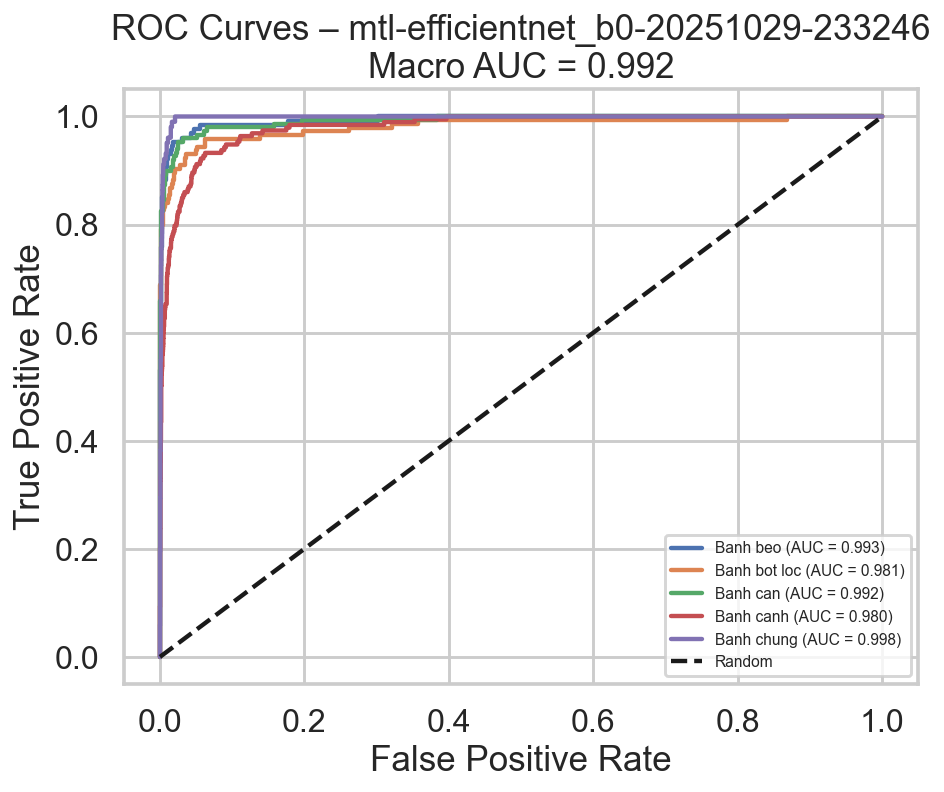

✓ Đã lưu: images\mtl-efficientnet_b0-20251029-233246_roc_auc.png


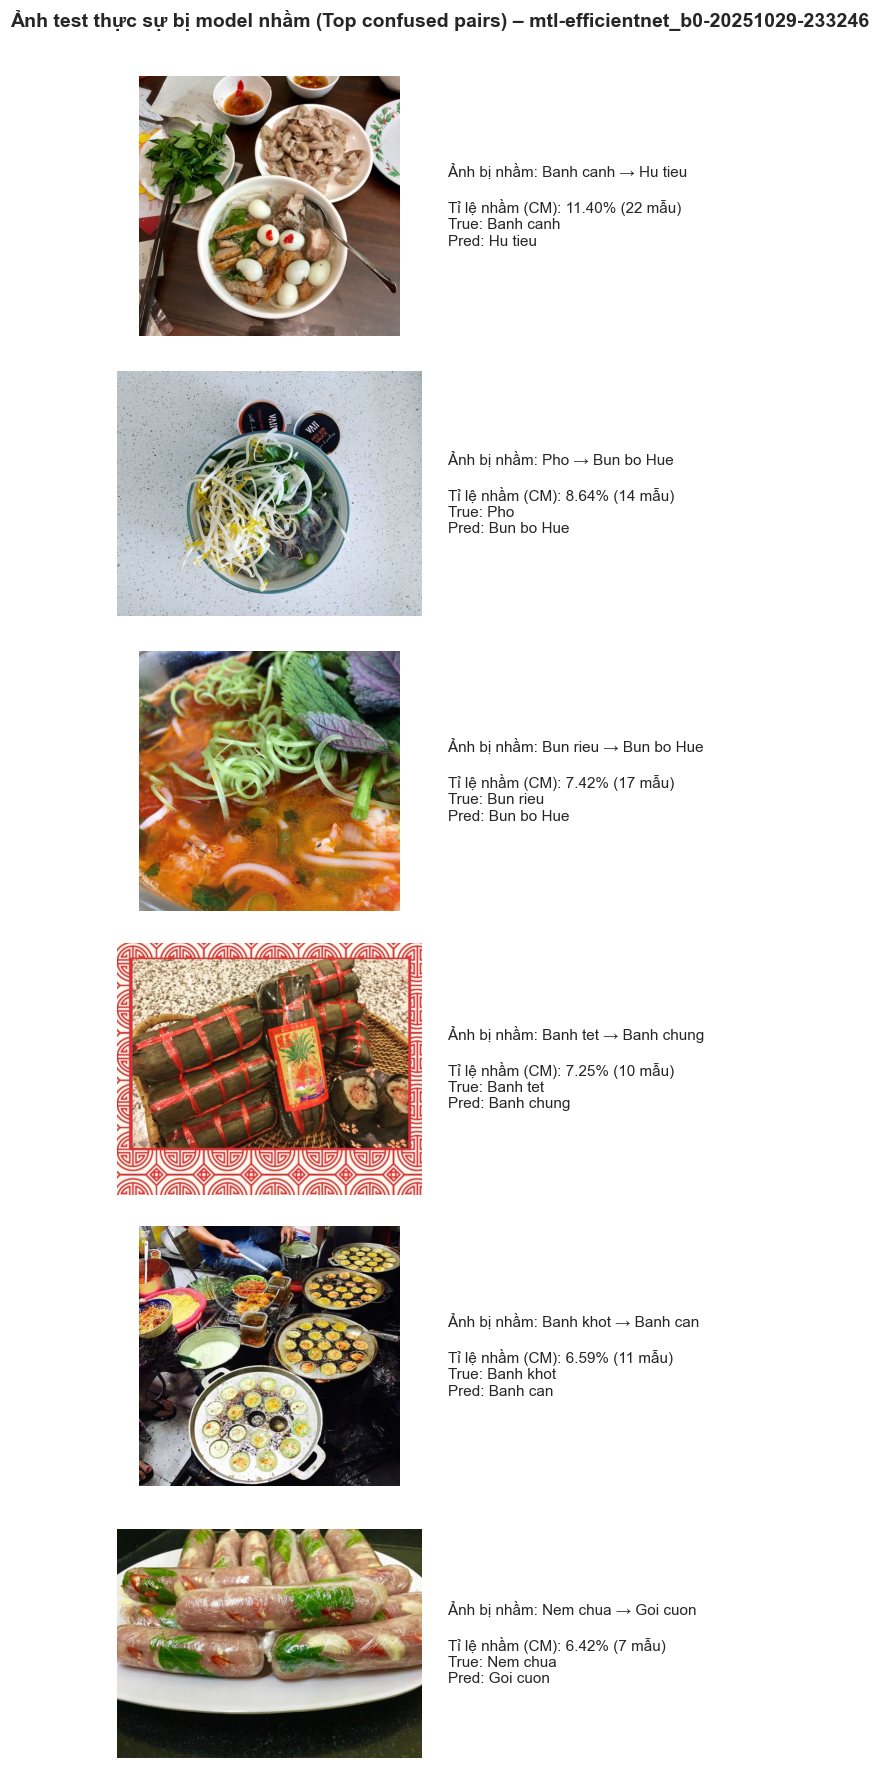

✓ Đã lưu: images\mtl-efficientnet_b0-20251029-233246_top_confused_pairs.png
⏱️ CustomEfficientNetB0: 15.08 ms/infer (66.3 FPS) | Params ≈ 4.05 M


C:\Users\Admin\AppData\Local\Temp\ipykernel_31584\3133259203.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)



=== ĐÁNH GIÁ MÔ HÌNH mtl-mobilenetv4-20251029-223758 ===
→ mtl-mobilenetv4-20251029-223758: macro AUC = 0.9895


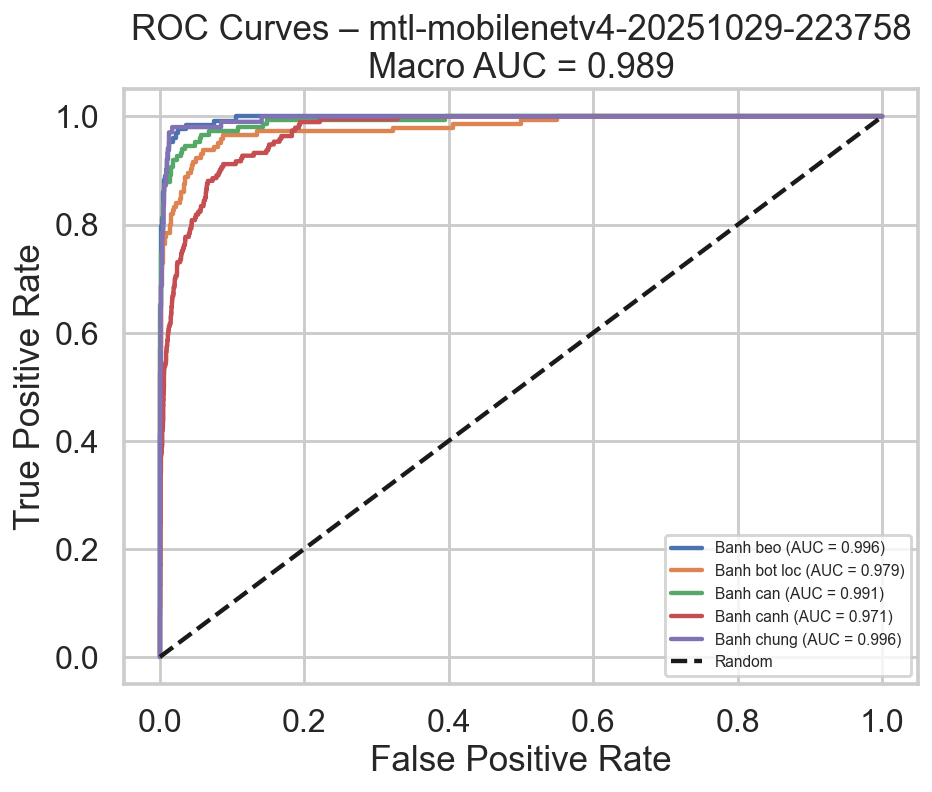

✓ Đã lưu: images\mtl-mobilenetv4-20251029-223758_roc_auc.png


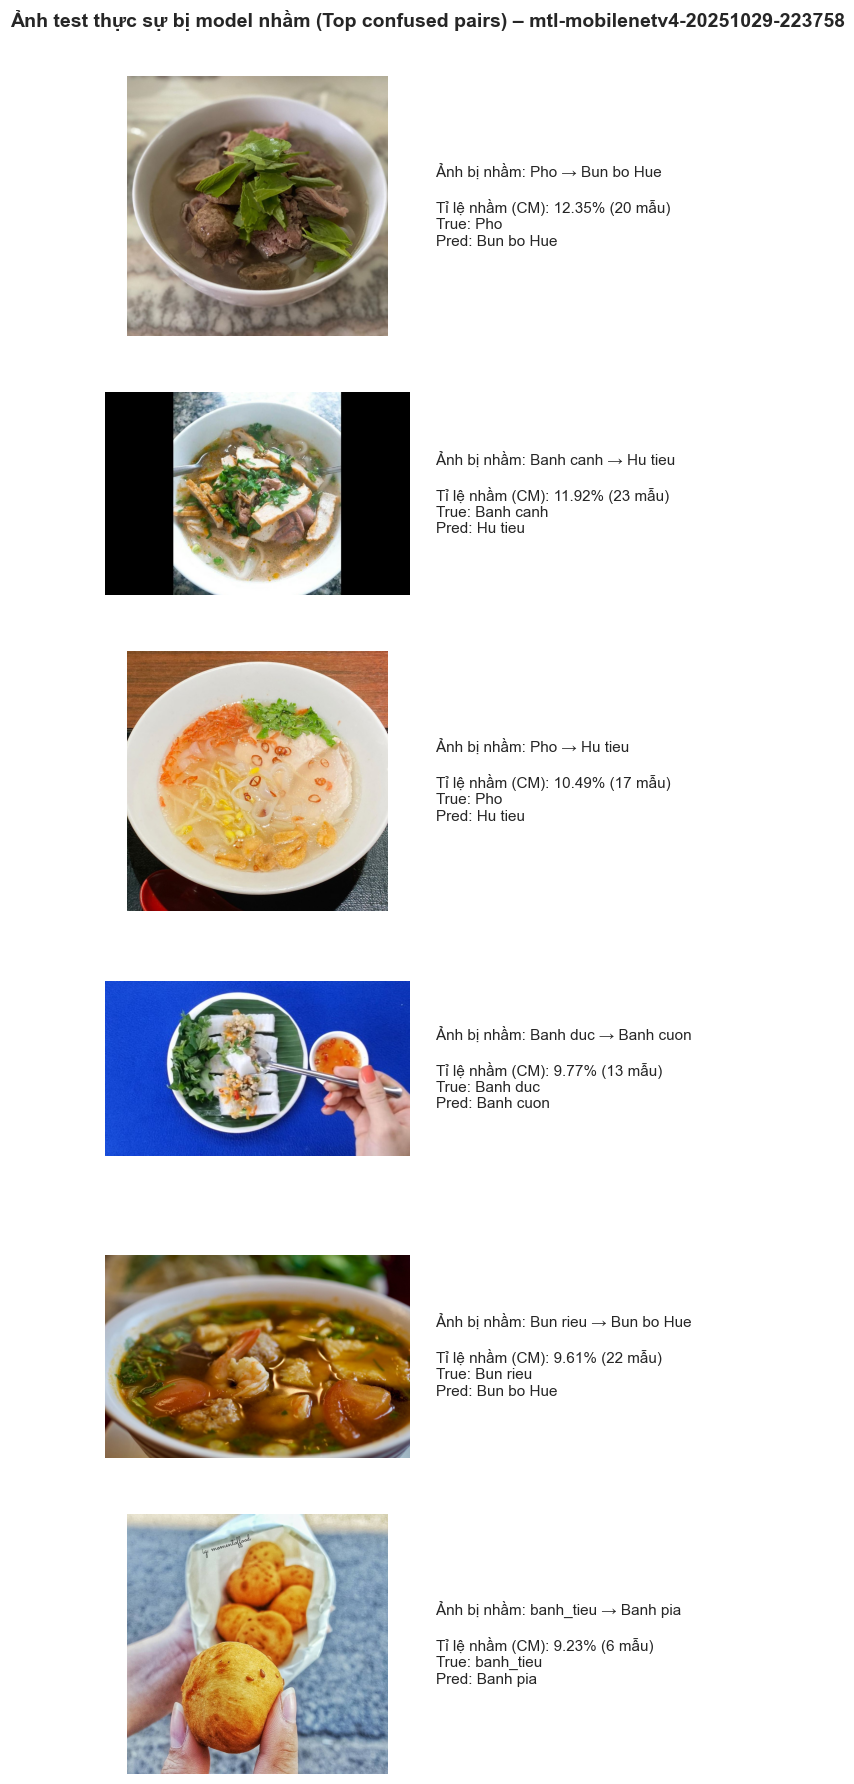

✓ Đã lưu: images\mtl-mobilenetv4-20251029-223758_top_confused_pairs.png
⏱️ CustomMobileNetV4: 7.03 ms/infer (142.3 FPS) | Params ≈ 2.54 M


In [245]:
# Giả sử bạn đã có results [] từ Cell 6 – chứa tên mỗi run
for r in results:
    run_name = r["run"]
    run_path = os.path.join("Runs", run_name)
    ckpt = pick_checkpoint(run_path)
    model = load_checkpoint(run_name, ckpt, device)
    print(f"\n=== ĐÁNH GIÁ MÔ HÌNH {run_name} ===")

    # 1️⃣ Inference & thu logits
    y_true, y_pred, y_prob = collect_logits(model, test_loader, device)

    # 2️⃣ Vẽ ROC & AUC
    plot_roc_auc_for_model(run_name, y_true, y_prob, class_names)

    # Visualize “Top Confused Pairs” (Ảnh bị nhầm nhiều nhất)
    show_top_confused_pairs(model, test_loader, class_names, run_name, device, top_k=6)

    # 4️⃣ Benchmark tốc độ
    benchmark_model(model, device, (1, 3, 224, 224))
